En este notebook modificaremos y emplearemos una red de tipo nnU-Net para obtener un detector de lesiones medulares en pacientes con Esclerosis Múltiple.
Trabajaremos con un conjunto de imágenes FLAIR propio, que dividiremos en entrenamiento y pruebas. En este conjunto las imágenes vienen agrupadas en grupos de dos:
* Imagen basal: contiene la imagen del paciente.
* Máscara de las lesiones: comprende el etiquetado final de la detección, de esta máscara tomaremos sólo las etiquetas marcadas con 1.

Las imágenes están en la carpeta lesiones de drive.

# 1. Descarga, análisis y pre-procesado de los datos 

## 1.1 Carga de librerias

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline 
try:
    import nibabel as nib #for loading data from NIfTI images
except:
    raise ImportError('Install NIBABEL')
from tqdm import tqdm
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from random import *
from skimage.io import imread
from glob import glob
from collections import OrderedDict
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import tensorflow as tf
from keras import backend as K

## 1.2. Conexión a Drive para la obtención de los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Establecemos nuestra ruta
root_dir = "/content/drive/MyDrive"

base_dir = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(base_dir)

# Listamos las imágenes
glob(os.path.join(root_dir,'lesiones','*'))

Mounted at /content/drive


[]

## 1.3. Análisis visual de los datos
Agrupamos las imágenes y las máscaras en dos conjuntos para facilitar la división en conjuntos de entrenamiento y test. El conjunto de test será nuestro conjunto de validación, ya que nnU-Net dividirá el conjunto de entrenamiento en entrenamiento y test.

In [ ]:
# Dividimos las imágenes en máscaras e imágenes de entrenamiento. Tomaremos la imagen más reciente del paciente como baseline.
total_imagenes =sorted(glob(os.path.join(root_dir,'Lesiones','*')))
mascaras = list(filter(lambda x: x.find("mask") !=-1, total_imagenes)) 
img_basales = list(filter(lambda x:x.endswith("0000.nii.gz") , total_imagenes))
img_seguimiento = list(filter(lambda x:x.endswith("0001.nii.gz") , total_imagenes) )
# Mostramos el total de imágenes y las primeras imágenes de cada lista
print(len(total_imagenes),' matching files found:',img_basales[0], img_seguimiento[0], mascaras[0])
print("img_seguimiento:",len(img_seguimiento))
print("mascaras:",len(mascaras))

352  matching files found: /content/drive/MyDrive/Lesiones/FIS_001_01_0000.nii.gz /content/drive/MyDrive/Lesiones/FIS_001_01_0001.nii.gz /content/drive/MyDrive/Lesiones/FIS_001_mask_def.nii.gz
img_seguimiento: 117
mascaras: 117


Mostramos un ejemplo visual de las imágenes con las que vamos a trabajar.

Text(0.5, 1.0, 'Máscara')

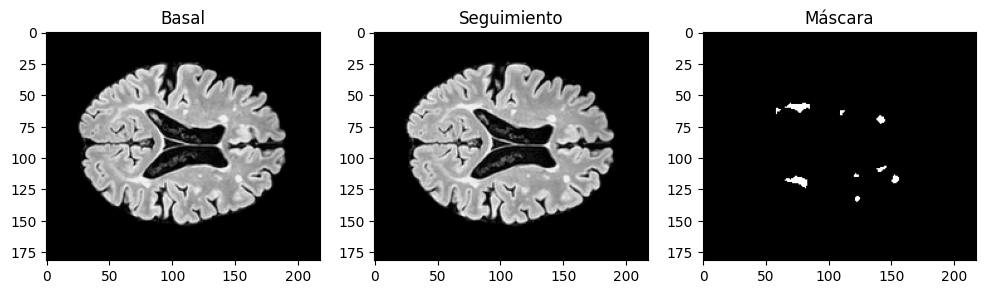

In [ ]:
# Mostramos unas imágenes al azar
x = randint(1, 117)
muestra_RMI = nib.load(img_basales[x]).get_fdata()
muestra_seg = nib.load(img_seguimiento[x]).get_fdata()
muestra_mascara = nib.load(mascaras[x]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_RMI[:, :, muestra_RMI.shape[2]//2],cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seg[:, :, muestra_seg.shape[2]//2],cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[:, :, muestra_mascara.shape[2]//2],cmap='gray')
ax3.set_title('Máscara')

# 2. Preparación y entrenamiento de nnU-Net

Aquí realizaremos los pasos necesarios para poder trabajar con el framework nnU-Net

## 2.1. Instalación de nnU-Net

Comenzamos instalando el framework.

In [ ]:
# Clonamos los datos de nnUNet para poder instalar
!git clone https://github.com/MIC-DKFZ/nnUNet.git

fatal: destination path 'nnUNet' already exists and is not an empty directory.


In [ ]:
# Declaramos el directorio raíz
nnunet_dir = '/content/drive/MyDrive/Colab Notebooks/nnUNet'
os.chdir(nnunet_dir)

In [ ]:
# Instalamos nnUNet
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/nnUNet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.4 MB/s e

In [ ]:
# Instalamos hiddenlayer para que nos muestre la tipología de red que va generando
!pip install --upgrade git+https://github.com/julien-blanchon/hiddenlayer.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/julien-blanchon/hiddenlayer.git to /tmp/pip-req-build-x6xk8sjn
  Running command git clone --filter=blob:none --quiet https://github.com/julien-blanchon/hiddenlayer.git /tmp/pip-req-build-x6xk8sjn
  Resolved https://github.com/julien-blanchon/hiddenlayer.git to commit 8e14b20dbe9888630b07d70e2a55cf080b5bd5a9
  Preparing metadata (setup.py) ... done
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-py3-none-any.whl size=19783 sha256=8a2b1f3395485508204337787ea2b5966054610d28c34984308c0fd064222023
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2_tpazq/wheels/a8/d7/ff/9a546c63a8b4ca9d619484b657dfbb44d4a70a450911423d9c
Successfully built hiddenlayer


## 2.2. Preparación del dataset dividiéndolo en imágenes y etiquetas para nnU-Net

Crearemos una estructura de carpetas adecuada a las necesidades de nnU-Net

In [ ]:
# Creamos la función para crear directorios si no existen
def make_if_dont_exist(folder_path,overwrite=False):    
    if os.path.exists(folder_path):
        # Si existe lo indicamos
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      # No existe creamos el directorio
      os.makedirs(folder_path)
      print(f"{folder_path} created!")
# Creamos la estructura de carpetas y distribuimos las imágenes
task_name = 'Dataset102_SLEM'
nnunet_dir = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
img_dir = '/content/drive/MyDrive/Lesiones'
# Creamos los directorios
make_if_dont_exist(task_folder_name+"/imagesTr",overwrite=False)
make_if_dont_exist(task_folder_name+"/imagesTs",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTr",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTs",overwrite=False)

train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')

test_image_dir = os.path.join(task_folder_name,'imagesTs')
test_label_dir = os.path.join(task_folder_name,'labelsTs')


/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs exists.


Tenemos 117 grupos de 3 imágenes cada uno (una imagen basal, una imagen actual y la etiqueta con la segmentación). Debemos dividir estas imágenes en conjuntos de entrenamiento y test. Aunque nnU-Net hace su propia división para entrenar los modelos, es interesante tener un conjunto para probar el rendimiento y comparar predicciones. Haremos una división 80%-20% para train y test. Usaremos las imágenes actuales de los pacientes, pues buscamos detectar lesiones.

In [ ]:
def copia_imagenes(origen, img_dir, image_dir, label_dir):
   ruta, file = os.path.split(origen)
   if file.endswith('.nii.gz'):
        # En ambos casos vamos a renombrar, tomamos el nombre original
        original_name = os.path.join(img_dir, file)

        # Separamos la base y la extensión
        base, extension = os.path.splitext(file)
        
        if file.find('mask')!=-1:
            # Tenemos una máscara, la renombramos para que el framework la reconozca
            # quitando '_mask_def' y quitamos las etiquetas 2
            original = nib.load(origen)
            elem = original.get_fdata()
            elem[elem == 2] = 0
            new_img = nib.Nifti1Image(elem, affine=original.affine, header=original.header)
            
            nueva_base = base.replace('_mask_def','')
            nueva_ruta = os.path.join(label_dir,nueva_base + extension)
            nib.save(new_img, nueva_ruta)  
        else:
            # Aquí también nos toca renombrar, vamos a quitar el _01_ 
            # central común a todas las imágenes
            nueva_base = base.replace('_01_','_')
            nueva_ruta = os.path.join(image_dir,nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)

# Vamos a hacer la división de forma manual
cantidad_tr = 94
cantidad_ts = 23
i = 0
while i < 117:
  x = randint(0, 10)
  if ( x > 5 and cantidad_ts > 0):
    image_dir = test_image_dir
    label_dir = test_label_dir
    cantidad_ts = cantidad_ts-1
  else:
    image_dir = train_image_dir
    label_dir = train_label_dir
  
  # Tomamos el archivo
  img_basal = img_basales[i]
  etiqueta = mascaras[i]

  copia_imagenes(img_basal, img_dir,image_dir,label_dir)
  copia_imagenes(etiqueta, img_dir,image_dir,label_dir)
  # Incrementamos i
  i = i+1

Verificamos que la copia de los datos fue correcta

In [ ]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print("train image files:",len(train_files))
print("train label files:",len(label_files))
print("Matches:",len(set(train_files).intersection(set(label_files))))

test_files = os.listdir(test_image_dir)
label_tfiles = os.listdir(test_label_dir)
print("test image files:",len(test_files))
print("test label files:",len(label_tfiles))

train image files: 94
train label files: 94
Matches: 0
test image files: 23
test label files: 23


Mostramos imágenes y etiquetas para ver que todo se hizo bien

Text(0.5, 1.0, 'Máscara')

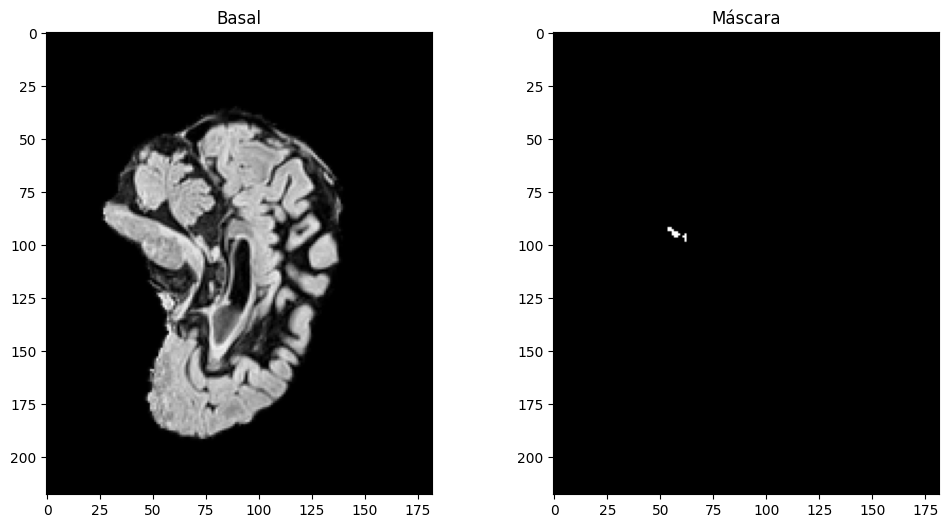

In [ ]:
# Mostramos unas imágenes al azar
x = randint(1, 94)
ruta_img = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTr'
ruta_lbl = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTr'
muestra_RMI = nib.load(os.path.join(ruta_img, train_files[x])).get_fdata()
muestra_mascara = nib.load(os.path.join(ruta_lbl, label_files[x])).get_fdata()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(muestra_RMI[muestra_RMI.shape[0]//2], cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_mascara[muestra_mascara.shape[0]//2], cmap='gray')
ax2.set_title('Máscara')

## 2.3 Configuración de nnU-Net

Ahora vamos a configurar nnU-Net para que se adapte a nuestro dataset

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name    

    #you may mention more than one modality
    json_dict['channel_names'] = {
        "0": "FLAIR"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "Lesions_without_changes": 1
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_label_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)
    json_dict['training'] = [{'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i in train_ids]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_ids]

    json_dict['file_ending'] = ".nii.gz"


    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=False)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


Creación de variables de entorno

In [ ]:
# Vamos a crear las variables de entorno
mount_dir = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2'
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data"), 
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"),
    "nnUNet_results" : os.path.join(mount_dir, "nnUNet_Results_Folder"),
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

!export nnUNet_raw=os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data")
!export nnUNet_preprocessed=os.path.join(mount_dir, "nnUNet_preprocessed")
!export nnUNet_results=os.path.join(mount_dir, "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder")

Current Working Directory /content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_preprocessed exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder exists.
If No Error Occured Continue Forward. =)
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_raw=os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data")'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_preprocessed=os.path.join(mount_dir, "nnUNet_preprocessed")'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_results=os.path.join(mount_dir, "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder")'


## 2.4. Verificación del dataset por parte de nnU-Net

In [ ]:
#running it from the experiment_planning folder to verify the path settings
main_dir = os.path.join(base_dir,'nnUNet/nnunetv2')
os.chdir(main_dir)
!nnUNetv2_plan_and_preprocess -d 102 --verify_dataset_integrity
os.chdir(main_dir)

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_plan_and_preprocess", line 33, in <module>
    sys.exit(load_entry_point('nnunetv2', 'console_scripts', 'nnUNetv2_plan_and_preprocess')())
  File "/usr/local/bin/nnUNetv2_plan_and_preprocess", line 25, i

## 2.5. Entrenamiento de nnU-Net

Ya tenemos todo listo para proceder con el entrenamiento de la red para segmentar nuevas lesiones.

In [ ]:
!nnUNetv2_train 102 3d_fullres 0 --c -tr nnUNetTrainer_100epochsCheck --npz

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################


This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [128, 128, 128], 'median_image_size_in_voxels': [182.0, 218.0, 182.0], 'spacing': [1.0, 1.0, 1.0], 'normalization_schemes': ['ZScoreNormalization'], 'use_mask_for_norm': [False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2], 'num_pool_per_axis': [5, 5, 5], 'po

##2.6. Determinación del mejor modelo obtenido

Ahora toca evaluar el mejor modelo de los tres obtenidos por nnU-Net.

In [ ]:
!nnUNetv2_find_best_configuration 102 -f 0 -c 3d_fullres -tr nnUNetTrainer_100epochsCheck


***All results:***
nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres: 0.729271634467171

*Best*: nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres: 0.729271634467171

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!

***Run inference like this:***

nnUNetv2_predict -d Dataset102_SLEM -i INPUT_FOLDER -o OUTPUT_FOLDER -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans

***Once inference is completed, run postprocessing like this:***

nnUNetv2_apply_postprocessing -i OUTPUT_FOLDER -o OUTPUT_FOLDER_PP -pp_pkl_file /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/crossval_results_folds_0/postprocessing.pkl -np 8 -plans_json /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/crossval_results_folds

## 2.7. Predicciones con nuestro mejor modelo

Ahora haremos predicciones con nuestro mejor modelo, para ello emplearemos la carpeta /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs y sus máscaras situadas en /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs

Lo primero que haremos será crear una carpeta para las predicciones

In [ ]:
# Creamos la carpeta para las predicciones,
# así tenemos todas guardadas para hacer la matriz de confusión
ruta_predic = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr'
make_if_dont_exist(ruta_predic, overwrite=False)

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr created!


Realizamos las predicciones sobre nuestro conjunto de test

In [ ]:
# Hacemos las predicciones
!nnUNetv2_predict -d Dataset102_SLEM -i "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs" -o "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr" -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 23 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 23 cases that I would like to predict
using pin_memory on device 0

Predicting FIS_001:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with FIS_001

Predicting FIS_005:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with FIS_005

Predicting FIS_013:
perform_ev

Realizaremos el postprocesado

In [ ]:
! nnUNetv2_apply_postprocessing -i "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr" -o "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/Salida_postprocesado" -pp_pkl_file "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/crossval_results_folds_0/postprocessing.pkl" 

## 2.8. Obtención del valor de DICE de nuestro modelo

 Comprobamos que la cantidad de imágenes es la misma y preparamos los dos conjuntos de datos a comparar.

In [ ]:
# Preparamos los dos conjuntos de datos para comparar
x_test = sorted(glob(os.path.join(task_folder_name,'imagesTs','*')))
y_true = sorted(glob(os.path.join(task_folder_name,'labelsTs','*')))
rutaPred = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM"
ficheros_p = sorted(glob(os.path.join(rutaPred,"Salida_postprocesado",'*')))
# Tomamos sólo las imágenes de las predicciones
y_pred = list(filter(lambda x:x.endswith(".nii.gz") , ficheros_p))
print("test files:",len(x_test))
print("true mask files:",len(y_true))
print("predicted mask files:",len(y_pred))

test files: 23
true mask files: 23
predicted mask files: 23


 Vamos a obtener el valor dice promedio y la desviación típica para ver la bondad de nuestro modelo.

In [ ]:
# Crearemos la función dice para evitar dividir por 0
def dice( y_true, y_pred):
    epsilon = 1e-2
    y_pred_arg = tf.math.argmax(y_pred, axis = -1)
    y_true_f = tf.cast(K.flatten(y_true), tf.int64)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.int64)
    intersection = tf.cast(K.sum(y_true_f * y_pred_f), tf.float32)
    dice = (2 * intersection + epsilon) / (tf.cast(K.sum(y_true_f), tf.float32) + tf.cast(K.sum(y_pred_f), tf.float32) + epsilon)
    return tf.cast(dice, tf.float32)



In [ ]:
valoresDICE = []

for i in range(23):  
   predict = nib.load(y_pred[i])
   prediction = np.asanyarray(predict.dataobj) 
   label = nib.load(y_true[i])
   mascara = np.asanyarray(label.dataobj)
   DICE = dice(mascara, prediction)
   valoresDICE.append(DICE)

Ya tenemos los valores de DICE de cada predicción en una lista, obtenemos la media y desviación

In [ ]:
# Ya tenemos la lista de valores, ahora obtenemos el promedio
media_DICE = np.mean(valoresDICE)
std_DICE = np.std(valoresDICE)

# Mostramos datos
print("Valor medio de DICE:",media_DICE)
print("Desviación típica de DICE:",std_DICE)

NameError: ignored

Hemos obtenido un valor medio de DICE de  0.7202178 y una desviación típica de 0.12391248

## 2.9. Matriz de confusión

Prepararemos la matriz de confusión para ver el desempeño de nuestra red. 

Realizamos una función para generar a mano la matríz de confusión.

In [ ]:
# Necesitaremos hacer nuestra función que genere la matriz de confusión a mano
def confusion_matrix(preds, labels, conf_m, sample_size):
    preds = preds.flatten()
    labels = labels.flatten()
    for i in range(len(preds)):
        #Comenzamos a rellenar 
        conf_m[int(preds[i]),int(labels[i])] += 1/(len(preds)*sample_size) 
    return conf_m



In [ ]:
conf_m = torch.zeros(2,2) # tenemos 2 clases
# Recorreremos las imágenes para ir sumando la matriz de confusion
for i in range(23):    
    prediction = nib.load(y_pred[i]).get_fdata()
    label = nib.load(y_true[i]).get_fdata()
    conf_m = confusion_matrix(prediction, label,conf_m, 23)

Visualizamos la matriz de confusión:

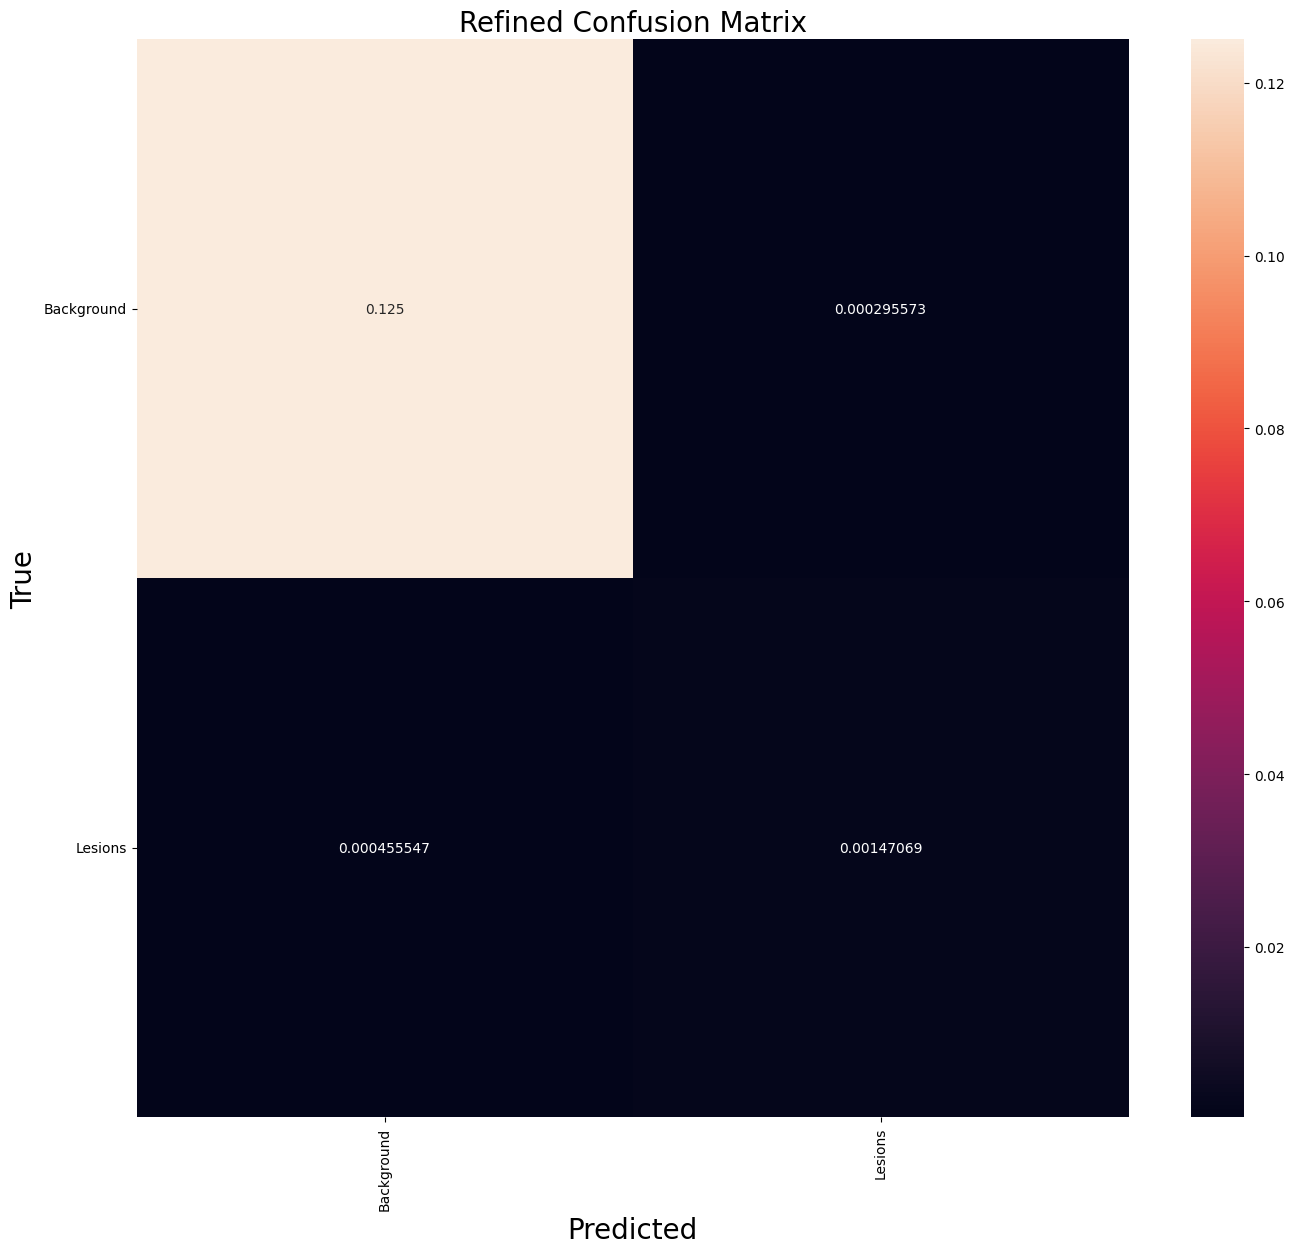

In [ ]:
#cm = confusion_matrix(y_true, y_pred)
## Indicamos las etiquetas
class_names = ['Background','Lesions']
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(conf_m, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# Damos formato a todo
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

## 2.10. Comparación visual de imágenes

Veamos de manera visual las imágenes segmentadas vs las máscaras

Text(0.5, 1.0, 'Prediccion')

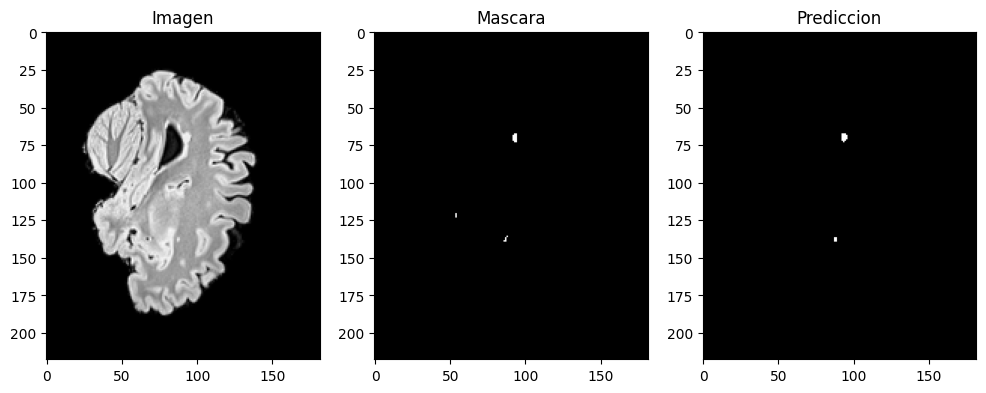

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[0]).get_fdata()
mascara = nib.load(y_true[0]).get_fdata()
prediccion =nib.load(y_pred[0]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

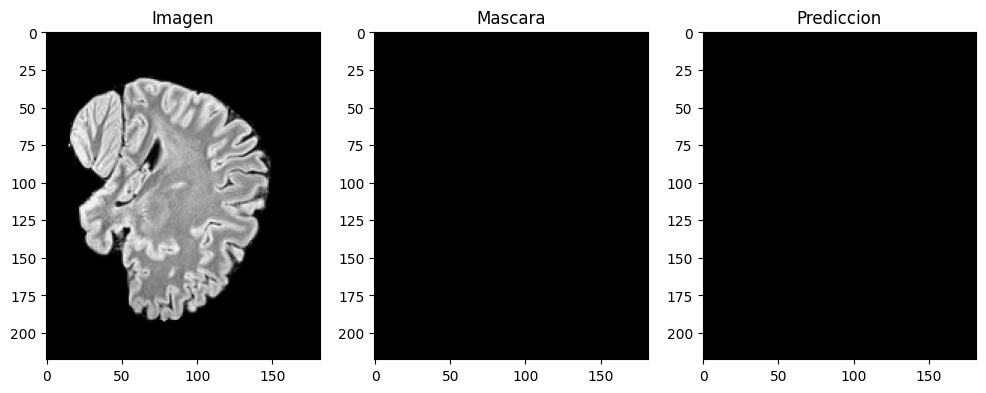

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[1]).get_fdata()
mascara = nib.load(y_true[1]).get_fdata()
prediccion =nib.load(y_pred[1]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

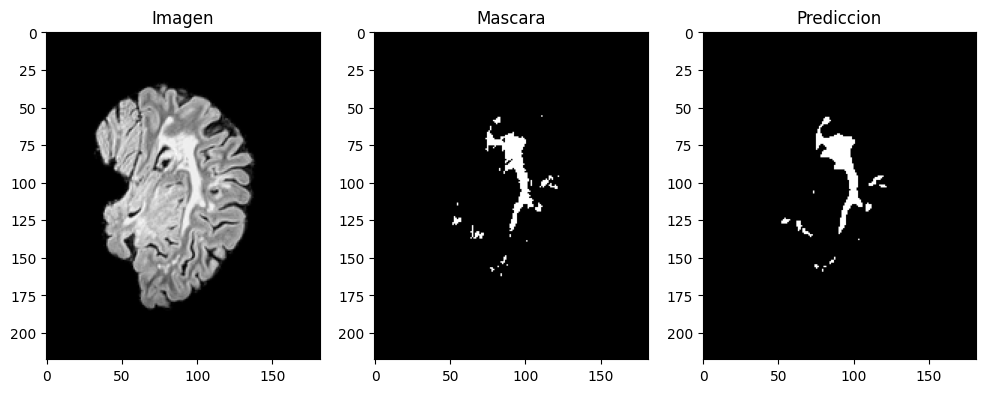

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[2]).get_fdata()
mascara = nib.load(y_true[2]).get_fdata()
prediccion =nib.load(y_pred[2]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

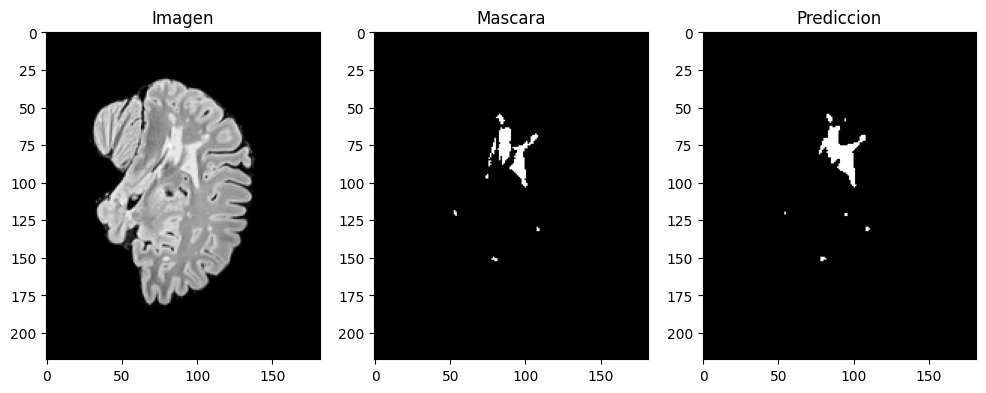

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[3]).get_fdata()
mascara = nib.load(y_true[3]).get_fdata()
prediccion =nib.load(y_pred[3]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

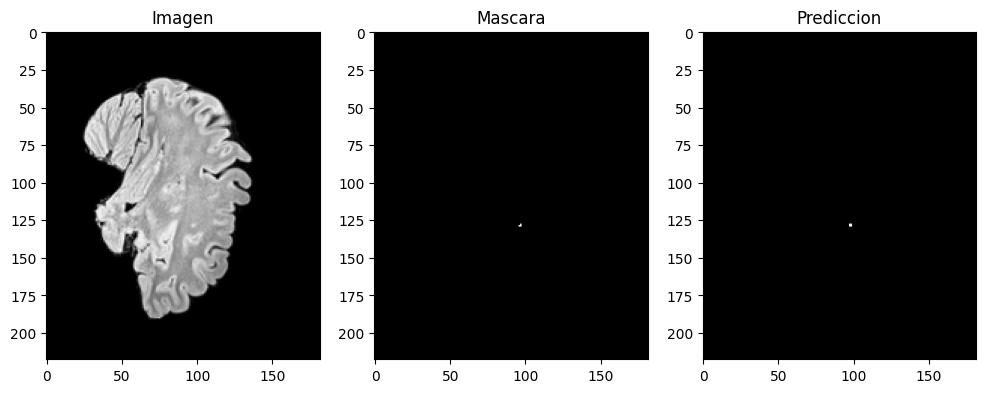

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[4]).get_fdata()
mascara = nib.load(y_true[4]).get_fdata()
prediccion =nib.load(y_pred[4]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

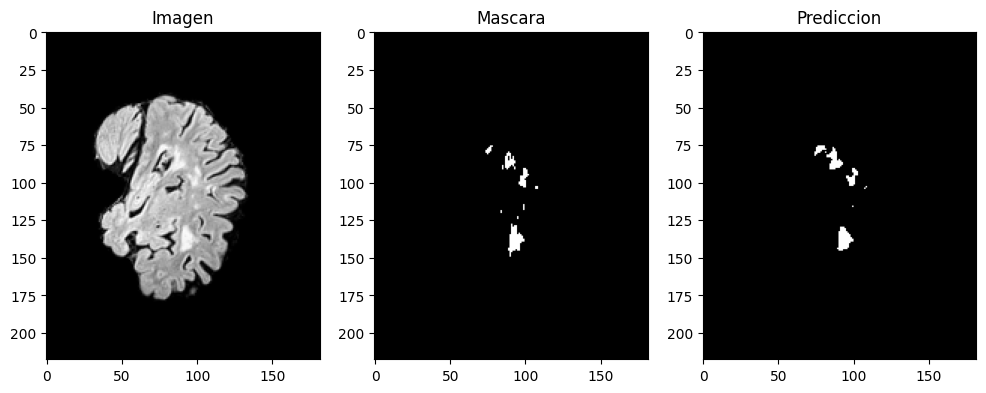

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[5]).get_fdata()
mascara = nib.load(y_true[5]).get_fdata()
prediccion =nib.load(y_pred[5]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

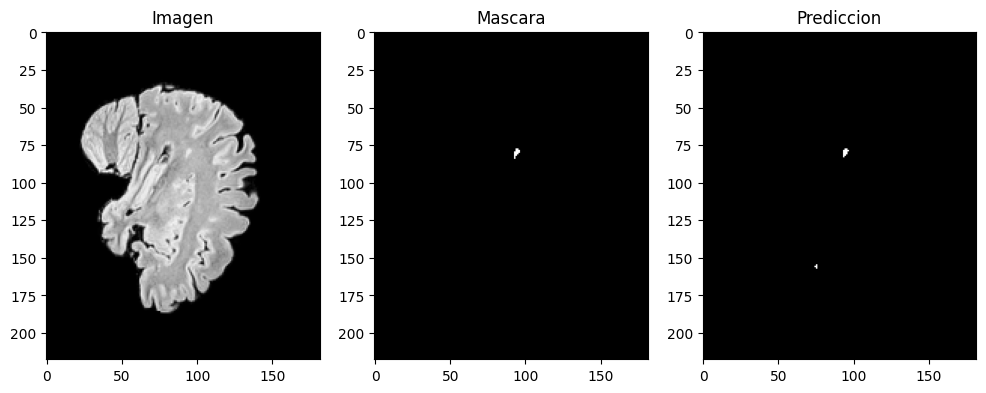

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[6]).get_fdata()
mascara = nib.load(y_true[6]).get_fdata()
prediccion =nib.load(y_pred[6]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

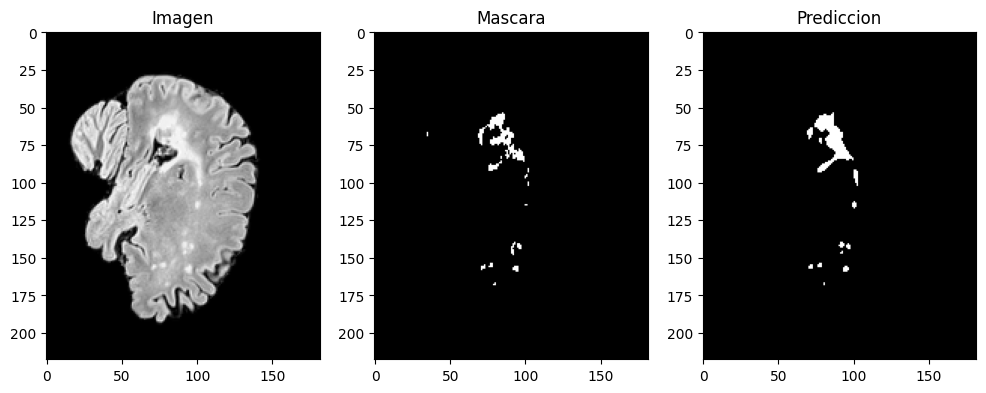

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[7]).get_fdata()
mascara = nib.load(y_true[7]).get_fdata()
prediccion =nib.load(y_pred[7]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

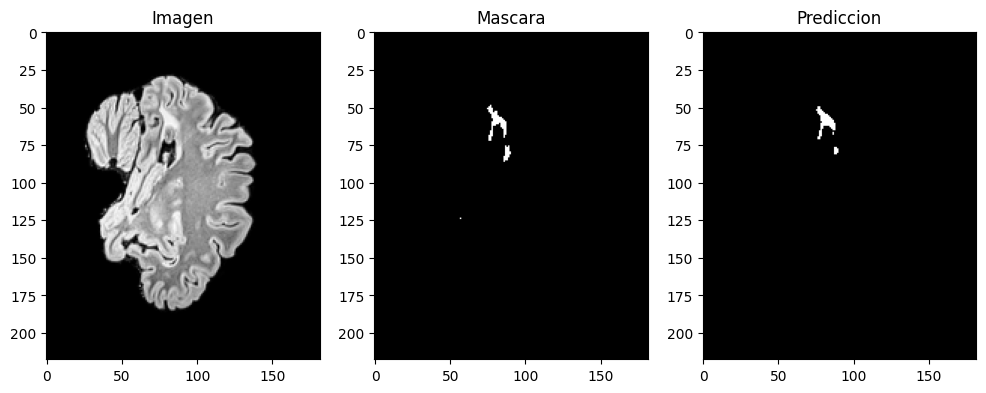

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[8]).get_fdata()
mascara = nib.load(y_true[8]).get_fdata()
prediccion =nib.load(y_pred[8]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

Text(0.5, 1.0, 'Prediccion')

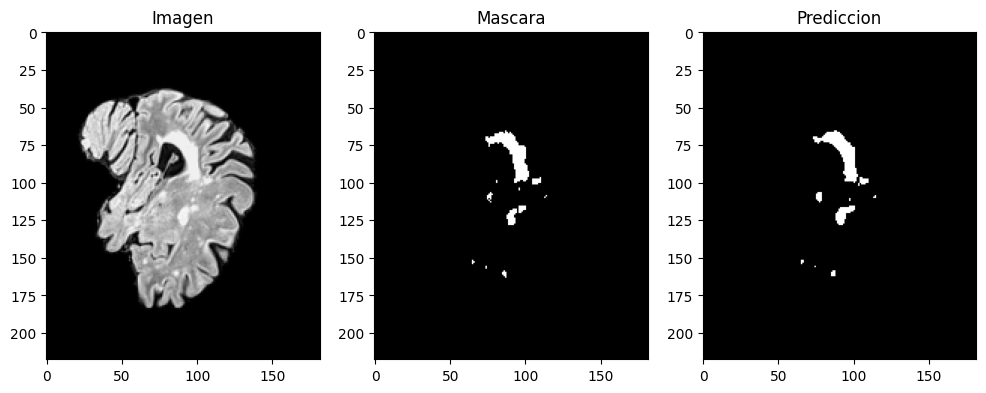

In [ ]:
# Mostramos la  primera imagen
imagen = nib.load(x_test[9]).get_fdata()
mascara = nib.load(y_true[9]).get_fdata()
prediccion =nib.load(y_pred[9]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(imagen[imagen.shape[0]//3],cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mascara[mascara.shape[0]//3],cmap='gray')
ax2.set_title('Mascara')
ax3.imshow(prediccion[prediccion.shape[0]//3],cmap='gray')
ax3.set_title('Prediccion')

# Detección de nuevas lesiones por el método de substracción

Como hemos obtenido un buen detector, para segmentar las nuevas lesiones haremos una predicción de la imagen basal, después una predicción de la imagen de seguimiento y mostraremos la resta de máscaras seguimiento-basal predichas. De este modo tendremos una máscara final con las lesiones nuevas.
Para ello vamos a desarrollar una función que realice esta labor.

In [ ]:
# Esta función recibe como entrada la carpeta en la que están las imágenes basal y seguimiento del paciente
# Nos devuelve la máscara con las nuevas lesiones del paciente
import subprocess

def detecta_nuevas_lesiones(dir_imagenes):
  # Creamos el directorio de salida
  path = os.path.join(dir_imagenes,"resultados")
  make_if_dont_exist(path, overwrite=False)
  # Obtenemos las lesiones de la imagen basal del paciente
  result = subprocess.check_output(f'nnUNetv2_predict -d Dataset102_SLEM -i "{dir_imagenes}" -o "{path}" -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans', shell=True)
  # Ahora tenemos el resultado de la RMI basal y la de seguimiento, toca restar
  total_imagenes =sorted(glob(os.path.join(dir_imagenes,'resultados','*')))
  basales = list(filter(lambda x: x.find("BAS") !=-1, total_imagenes))
  seguimientos = list(filter(lambda x: x.find("SEG") !=-1 , total_imagenes))
  masc_basal = basales[0]
  masc_seg = seguimientos[0]
  # Ya tenemos la máscara basal y la de seguimiento, ahora a restar
  img_basal = nib.load(masc_basal)
  # Convertimos la imagen en matriz
  matriz_basal = img_basal.get_fdata()
  # Ahora con la de seguimiento
  img_seg = nib.load(masc_seg)
  # Convertimos la imagen en matriz
  matriz_seg = img_seg.get_fdata()

  matriz_resultado = matriz_seg - matriz_basal
  # Nos interesa tener sólo las lesiones nuevas, por lo que aquellas que 
  # han desaparecido o han encogido las ignoraremos, dándoles valor 0
  #matriz_resultado[matriz_resultado < 0] = 0
  matriz_final =  np.where(matriz_resultado < 0, 0, matriz_resultado)

  # Guardamos la matriz resultado
  new_img = nib.Nifti1Image(matriz_final, affine=img_seg.affine, header=img_seg.header)

  # Daremos nombre al resultado
  ruta, file = os.path.split(masc_basal)
  # Separamos la base y la extensión
  base, extension = os.path.splitext(file)
  nueva_base = base.replace('BAS_','')
  base_definitiva = nueva_base.replace('0000','mask')
  
  nueva_ruta = os.path.join(path, base_definitiva + extension)
  nib.save(new_img, nueva_ruta)  
  
  # Eliminamos los temporales
  dirBorrar = dir_imagenes+'/resultados'
  test = os.listdir(dirBorrar)
  for item in test:
      if (item.startswith("BAS") or item.startswith("SEG")):
          os.remove(os.path.join(path, item))

# detecta_nuevas_lesiones('/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias')

Text(0.5, 1.0, 'Máscara')

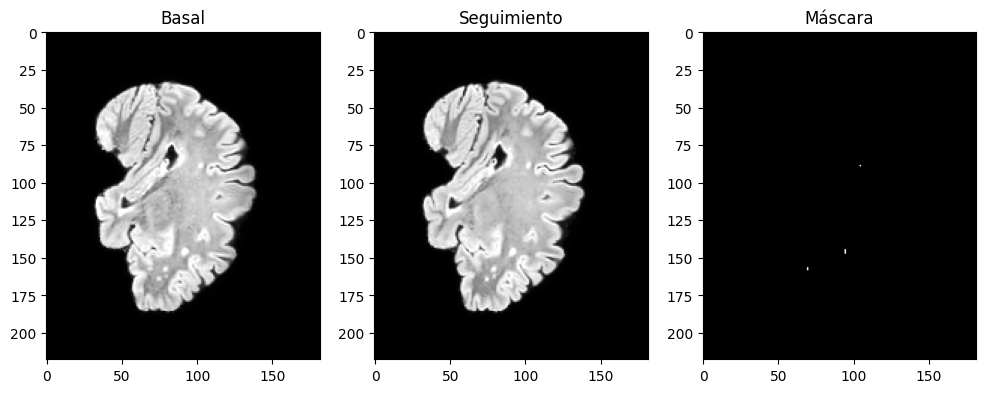

In [ ]:
# Mostramos los resultados
dir_raiz = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias'
dir_orig = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM'
total_imagenes =sorted(glob(os.path.join(dir_orig,'Test_diferencias','*')))
total_mask =sorted(glob(os.path.join(dir_raiz,'resultados','*')))
mascaras = list(filter(lambda x: x.find("Mascara") !=-1, total_mask)) 
img_basales = list(filter(lambda x: x.find("BAS") !=-1 , total_imagenes))
img_seguimiento = list(filter(lambda x: x.find("SEG") !=-1 , total_imagenes) )
muestra_RMI = nib.load(img_basales[0]).get_fdata()
muestra_seg = nib.load(img_seguimiento[0]).get_fdata()
muestra_mascara = nib.load(mascaras[0]).get_fdata()
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_RMI[muestra_RMI.shape[0]//3],cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seg[muestra_seg.shape[0]//3],cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[muestra_mascara.shape[0]//3],cmap='gray')
ax3.set_title('Máscara')

# Detección de lesiones basales y nuevas lesiones por el método de suma de matrices

No nos quedaremos sólo con un detector de lesiones nuevas, necesitamos crear uno con las lesiones basales con valor 1 y las nuevas con valor 2. Para ello en lugar de restar matrices, las sumaremos. El resultado nos dará un valor 2 para aquellas lesiones comunes en ambas imágenes (las basales sin cambios) y 1 en las nuevas lesiones que sólo aparecen en la imagen de seguimiento. Para normalizar esos valores debemos invertir después los valores para que queden como 1 las lesiones basales y 2 las nuevas lesiones. Como se puede observar, todo se reduce a operaciones sencillas de matrices.

In [ ]:
import subprocess
def detector_multiclase(dir_imagenes):
  # Creamos el directorio de salida
  path = os.path.join(dir_imagenes,"resultados_multiclase_tm")
  make_if_dont_exist(path, overwrite=False)
  # Obtenemos las lesiones de la imagen basal del paciente
  result = subprocess.check_output(f'nnUNetv2_predict -d Dataset102_SLEM -i "{dir_imagenes}" -o "{path}" -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans', shell=True)
  # Ahora tenemos el resultado de la RMI basal y la de seguimiento, toca restar
  total_imagenes =sorted(glob(os.path.join(dir_imagenes,'resultados_multiclase_tm','*')))
  basales = list(filter(lambda x: x.find("BAS") !=-1, total_imagenes))
  seguimientos = list(filter(lambda x: x.find("SEG") !=-1 , total_imagenes))
  masc_basal = basales[0]
  masc_seg = seguimientos[0]
  # Ya tenemos la máscara basal y la de seguimiento, ahora a sumarlas
  img_basal = nib.load(masc_basal)
  # Convertimos la imagen en matriz
  matriz_basal = img_basal.get_fdata()
  # Ahora con la de seguimiento
  img_seg = nib.load(masc_seg)
  # Convertimos la imagen en matriz
  matriz_seg = img_seg.get_fdata()

  # Sumamos ambas matrices, esto nos dará como resultado una matriz que tendrá
  # valor 2 para las imágenes basales y valor 1 para las nuevas. Esto no sirve
  # por lo que transformaremos valores para que al final queden las lesiones
  # basales como 1 y las nuevas como 2
  matriz_resultado = matriz_seg + matriz_basal
  # Transformamos valores
  # Damos un valor absurdo, 3, a las de tipo 2
  #matriz_resultado[matriz_resultado == 2] = 3
  matriz_final =  np.where(matriz_resultado == 2, 3, matriz_resultado)
  # Damos valor 2 a las de tipo 1
  matriz_final =  np.where(matriz_final == 1, 2, matriz_final)
  #matriz_resultado[matriz_resultado == 1] = 2
  # Damos valor 1 a las de valor 3
  matriz_final =  np.where(matriz_final == 3, 1, matriz_final)
  #matriz_resultado[matriz_resultado == 3] = 1
  # Guardamos la matriz resultado con los valores correctos
  new_img = nib.Nifti1Image(matriz_resultado, affine=img_seg.affine, header=img_seg.header)
  
   # Daremos nombre al resultado
  ruta, file = os.path.split(masc_basal)
  # Separamos la base y la extensión
  base, extension = os.path.splitext(file)
  nueva_base = base.replace('BAS_','')
  base_definitiva = nueva_base.replace('0000','mask')
  
  nueva_ruta = os.path.join(path, base_definitiva + extension)
  nib.save(new_img, nueva_ruta)  

  # Eliminamos los temporales
  dirBorrar = dir_imagenes+'/resultados_multiclase_tm'
  test = os.listdir(dirBorrar)
  for item in test:
      if (item.startswith("BAS") or item.startswith("SEG")):
          os.remove(os.path.join(path, item))

#detector_multiclase('/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias')

Veamos si ha funcionado bien

Text(0.5, 1.0, 'Máscara')

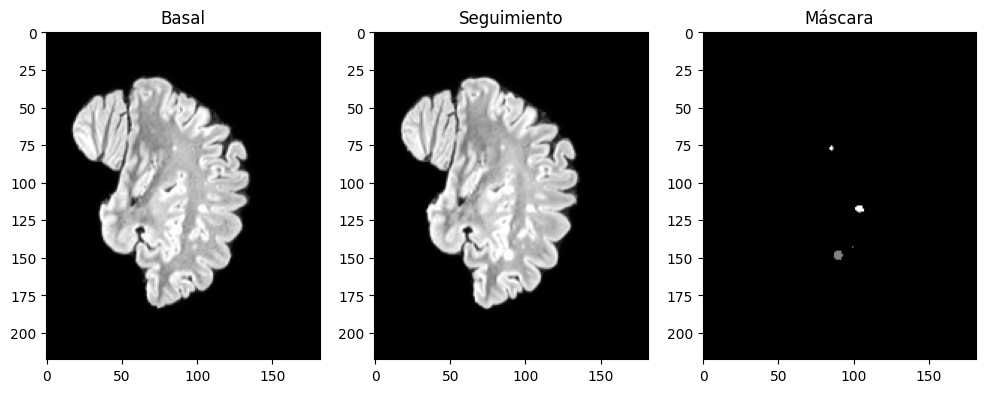

In [ ]:
# Mostramos los resultados
dir_raiz = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias'
dir_orig = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM'
total_imagenes =sorted(glob(os.path.join(dir_orig,'Test_diferencias','*')))
total_mask =sorted(glob(os.path.join(dir_raiz,'resultados_multiclase','*')))
mascaras = list(filter(lambda x: x.find("Mascara") !=-1, total_mask)) 
img_basales = list(filter(lambda x: x.find("BAS") !=-1 , total_imagenes))
img_seguimiento = list(filter(lambda x: x.find("SEG") !=-1 , total_imagenes) )
muestra_RMI = nib.load(img_basales[0]).get_fdata()
muestra_seg = nib.load(img_seguimiento[0]).get_fdata()
muestra_mascara = nib.load(mascaras[0]).get_fdata()
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_RMI[muestra_RMI.shape[0]//3],cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seg[muestra_seg.shape[0]//3],cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[muestra_mascara.shape[0]//3],cmap='gray')
ax3.set_title('Máscara')

## Testeo del detector multiclase por el método de suma de matrices con las imágenes de ImaginEM

Se probará el modelo con las imágenes de test del conjunto de datos inicial

In [ ]:
## Usaremos el dataset del detector original
task_name2 = 'Dataset101_SLEM'
nnunet_dir2 = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name2 = os.path.join(nnunet_dir2,task_name2)

In [ ]:
root_dir = "/content/drive/MyDrive"
# Dividimos las imágenes en máscaras e imágenes de entrenamiento. Tomaremos la imagen más reciente del paciente como baseline.
total_imagenes_TM =sorted(glob(os.path.join(task_folder_name,'imagesTs_MS','*')))
total_mascaras_TM =sorted(glob(os.path.join(task_folder_name,'labelsTs_MS','*')))
mascaras_TM = list(filter(lambda x: x.find(".nii.gz") !=-1, total_mascaras_TM)) 
img_basales_TM = list(filter(lambda x: x.find("0000") !=-1 , total_imagenes_TM))
img_seguimiento_TM = list(filter(lambda x: x.find("0001") !=-1 , total_imagenes_TM) )
# Mostramos el total de imágenes y las primeras imágenes de cada lista
print("Total_imagenes:",len(total_imagenes_TM))
print("img_basales:",len(img_basales_TM))
print("img_seguimiento:",len(img_seguimiento_TM))
print("mascaras:",len(mascaras_TM))

Total_imagenes: 46
img_basales: 23
img_seguimiento: 23
mascaras: 23


In [ ]:
# Código para transformar las imágenes a un formato que le guste a nnU-Net
def copia_imagenes_test_tm(origen, img_dir, image_dir, label_dir):
   ruta, file = os.path.split(origen)
   if file.endswith('.nii.gz'):
        # En ambos casos vamos a renombrar, tomamos el nombre original
        original_name = os.path.join(img_dir, file)

        # Separamos la base y la extensión
        base, extension = os.path.splitext(file)
        
        if file.find('mask')!=-1:
            # Tenemos una máscara, la renombramos para que el framework la reconozca
            # quitando '_mask_def'
            # nueva_base = base.replace('_mask_def','')
            nueva_ruta = os.path.join(label_dir,base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        elif file.find('0000')!=-1:
            nueva_base = base.replace('time01_FL','0000')
            nueva_ruta = os.path.join(image_dir,"BAS_"+nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        elif file.find('0001')!=-1:
            nueva_base = base.replace('0001','0000')
            nueva_ruta = os.path.join(image_dir,"SEG_"+nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)

In [ ]:
test_image_dir = os.path.join(task_folder_name,'imagesTs_MS')
test_label_dir = os.path.join(task_folder_name,'labelsTs_MS')

dir_destino = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias'
dir_origen = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS'
i = 0
while i <23:
  image_dir = test_image_dir
  
  # Tomamos el archivo
  img_basal = img_basales_TM[i]
  img_seg = img_seguimiento_TM[i]

  copia_imagenes_test_tm(img_basal, dir_origen,dir_destino,dir_destino)
  copia_imagenes_test_tm(img_seg, dir_origen,dir_destino,dir_destino)
  detector_multiclase(dir_destino)
  # Borramos ficheros copiados para volver a empezar
  test = os.listdir(dir_destino)

  for item in test:
      if item.endswith(".nii.gz"):
          if os.path.exists(os.path.join(dir_destino, item)):
            os.remove(os.path.join(dir_destino, item))
  # Incrementamos i
  i = i+1

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunet

### Obtención del valor de DICE de nuestro modelo con ImaginEM

Vamos a obtener el valor dice promedio y la desviación típica para ver la bondad de nuestro modelo:


In [ ]:
# Preparamos los dos conjuntos de datos para comparar
test_folder_name = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias'
x_test = sorted(glob(os.path.join(task_folder_name,'imagesTs_MS','*')))
y_true = sorted(glob(os.path.join(task_folder_name,'labelsTs_MS','*')))

ficheros_p = sorted(glob(os.path.join(test_folder_name,"resultados_multiclase_tm",'*')))
# Tomamos sólo las imágenes de las predicciones
y_pred = list(filter(lambda x:x.endswith(".nii.gz") , ficheros_p))
print("test files:",len(x_test))
print("true mask files:",len(y_true))
print("predicted mask files:",len(y_pred))

test files: 46
true mask files: 23
predicted mask files: 23


In [ ]:
# Crearemos la función dice para evitar dividir por 0
def dice( y_true, y_pred):
    epsilon = 1e-2
    y_pred_arg = tf.math.argmax(y_pred, axis = -1)
    y_true_f = tf.cast(K.flatten(y_true), tf.int64)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.int64)
    intersection = tf.cast(K.sum(y_true_f * y_pred_f), tf.float32)
    dice = (2 * intersection + epsilon) / (tf.cast(K.sum(y_true_f), tf.float32) + tf.cast(K.sum(y_pred_f), tf.float32) + epsilon)
    return tf.cast(dice, tf.float32)

In [ ]:
valoresDICE = []

for i in range(23):  
   predict = nib.load(y_pred[i])
   prediction = np.asanyarray(predict.dataobj) 
   label = nib.load(y_true[i])
   mascara = np.asanyarray(label.dataobj)
   DICE = dice(mascara, prediction)
   valoresDICE.append(DICE)
   
# Ya tenemos la lista de valores, ahora obtenemos el promedio
media_DICE = np.mean(valoresDICE)
std_DICE = np.std(valoresDICE)

# Mostramos datos
print("Valor medio de DICE:",media_DICE)
print("Desviación típica de DICE:",std_DICE)

Valor medio de DICE: 0.85585594
Desviación típica de DICE: 0.21967392


### Muestra visual de los resultados
A continuación se muestran los resultados de forma visual

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_001_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_001_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_001_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_001_01.nii.gz
tf.Tensor(0.8395351, shape=(), dtype=float32)


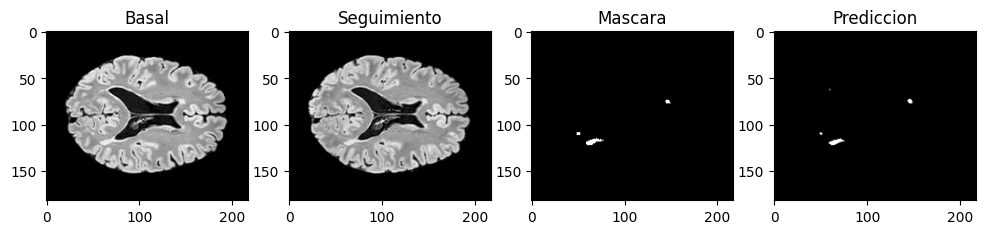

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_005_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_005_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_005_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_005_01.nii.gz
tf.Tensor(0.5369739, shape=(), dtype=float32)


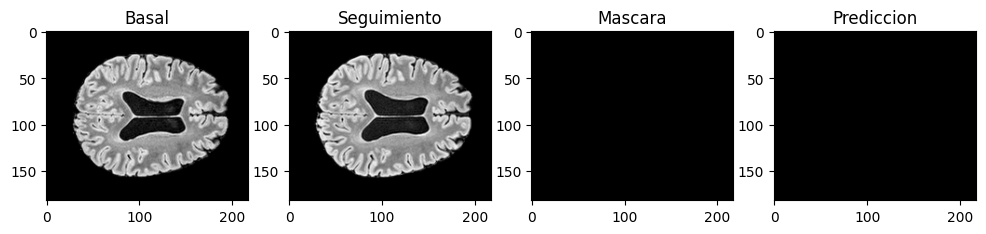

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_013_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_013_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_013_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_013_01.nii.gz
tf.Tensor(1.0332181, shape=(), dtype=float32)


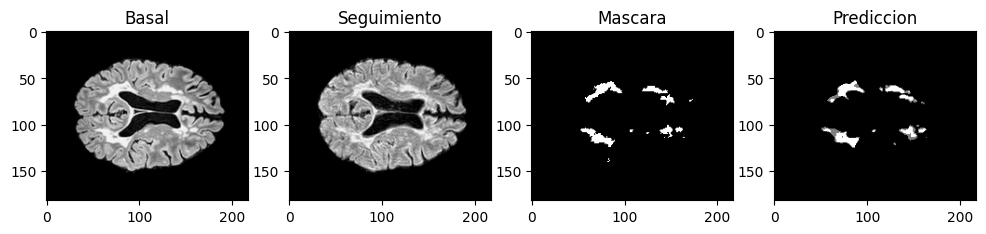

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_017_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_017_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_017_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_017_01.nii.gz
tf.Tensor(1.1107278, shape=(), dtype=float32)


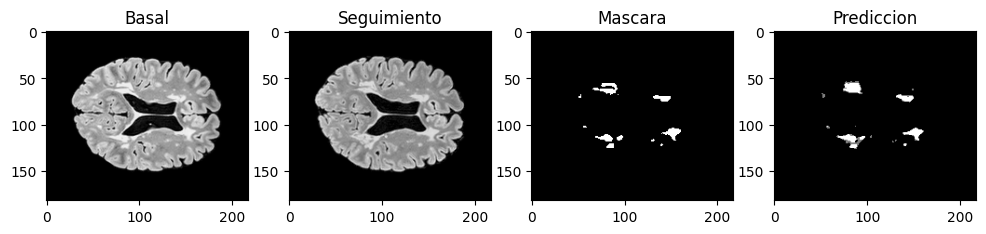

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_020_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_020_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_020_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_020_01.nii.gz
tf.Tensor(0.7063411, shape=(), dtype=float32)


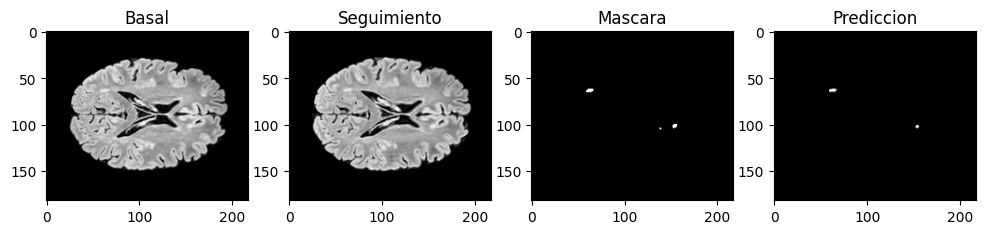

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_024_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_024_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_024_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_024_01.nii.gz
tf.Tensor(1.1593511, shape=(), dtype=float32)


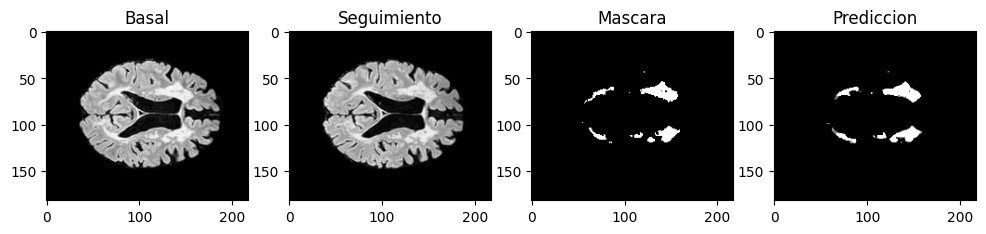

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_025_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_025_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_025_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_025_01.nii.gz
tf.Tensor(0.30210993, shape=(), dtype=float32)


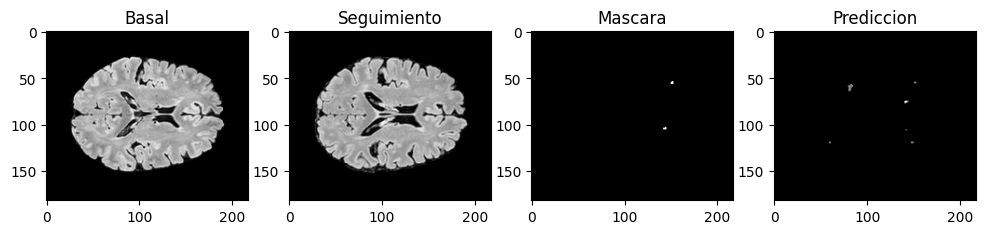

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_031_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_031_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_031_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_031_01.nii.gz
tf.Tensor(0.9125177, shape=(), dtype=float32)


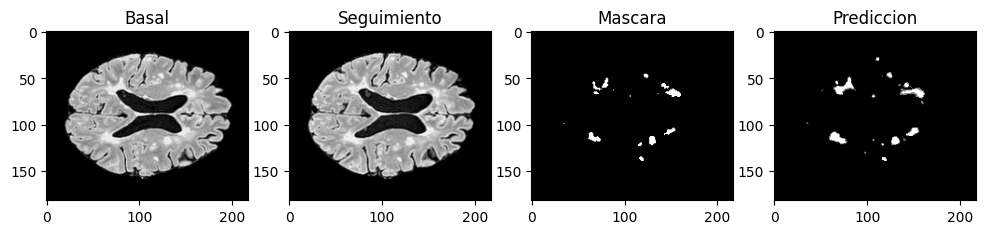

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_033_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_033_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_033_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_033_01.nii.gz
tf.Tensor(0.96905893, shape=(), dtype=float32)


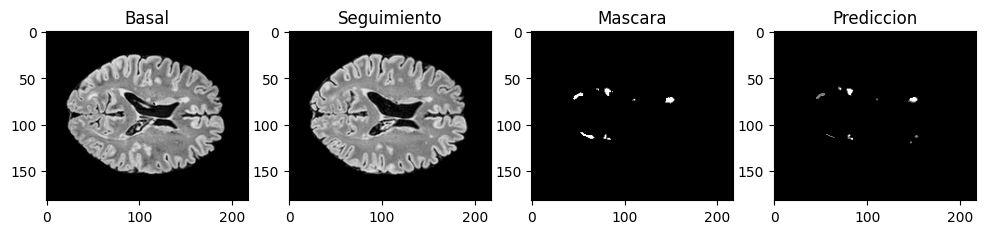

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_041_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_041_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_041_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_041_01.nii.gz
tf.Tensor(1.0407975, shape=(), dtype=float32)


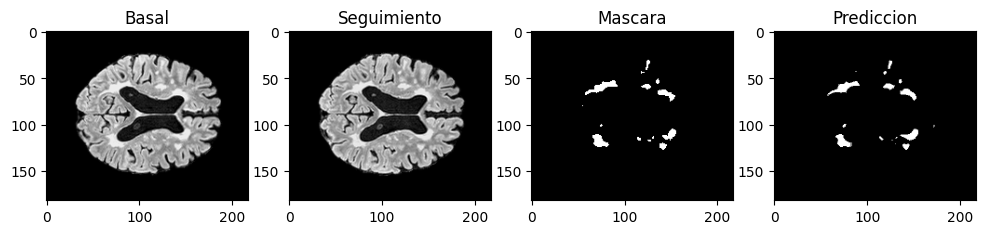

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_046_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_046_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_046_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_046_01.nii.gz
tf.Tensor(0.5659116, shape=(), dtype=float32)


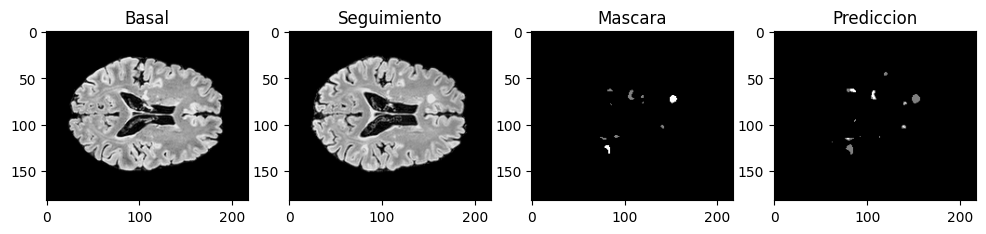

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_061_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_061_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_061_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_061_01.nii.gz
tf.Tensor(0.9950659, shape=(), dtype=float32)


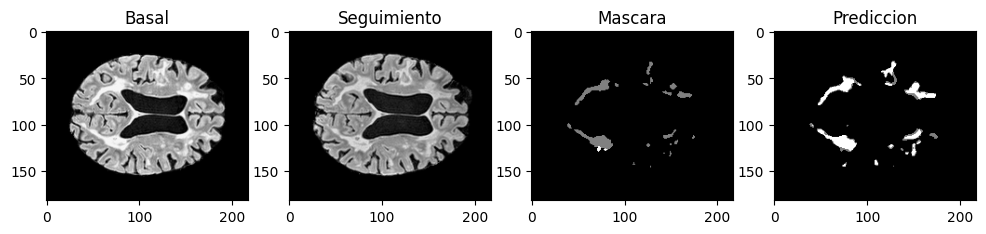

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_066_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_066_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_066_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_066_01.nii.gz
tf.Tensor(0.8633511, shape=(), dtype=float32)


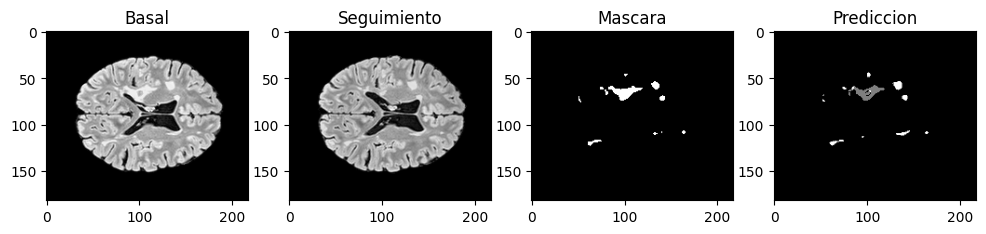

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_067_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_067_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_067_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_067_01.nii.gz
tf.Tensor(0.84402823, shape=(), dtype=float32)


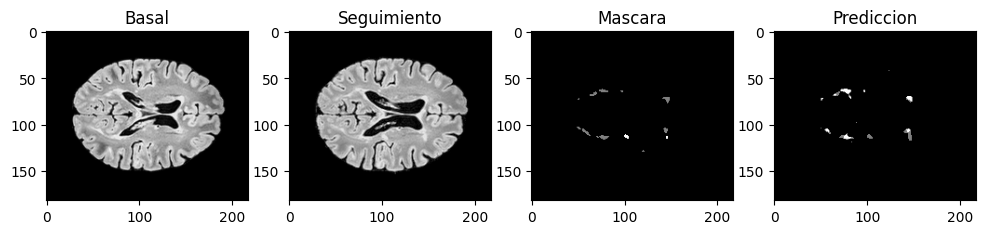

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_068_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_068_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_068_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_068_01.nii.gz
tf.Tensor(0.9315375, shape=(), dtype=float32)


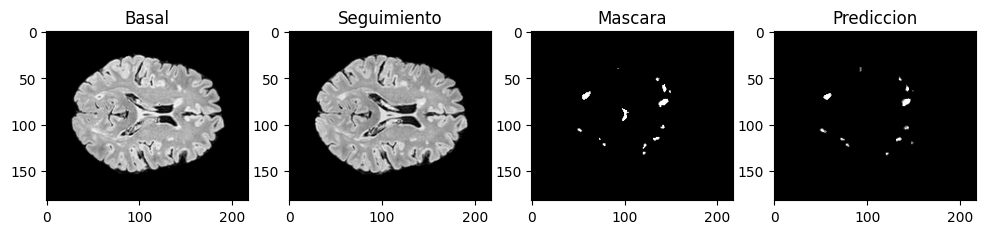

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_075_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_075_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_075_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_075_01.nii.gz
tf.Tensor(0.52059704, shape=(), dtype=float32)


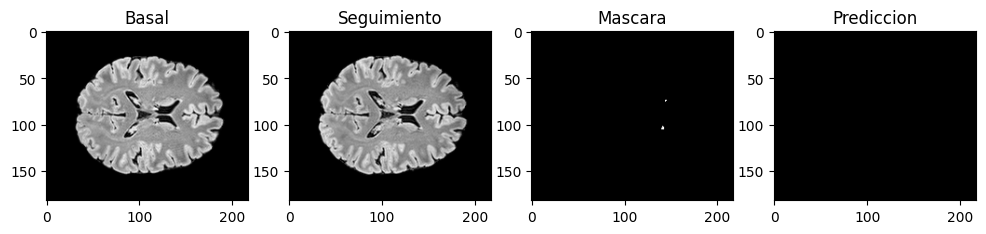

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_086_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_086_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_086_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_086_01.nii.gz
tf.Tensor(1.0088334, shape=(), dtype=float32)


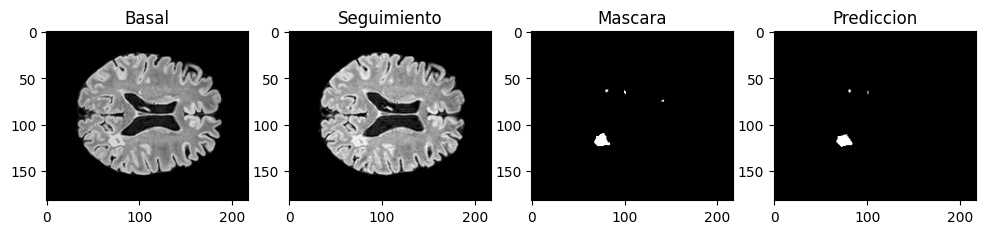

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_088_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_088_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_088_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_088_01.nii.gz
tf.Tensor(0.9170911, shape=(), dtype=float32)


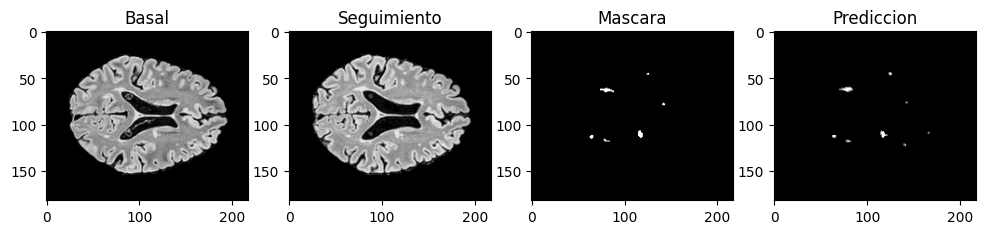

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_096_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_096_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_096_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_096_01.nii.gz
tf.Tensor(0.7267886, shape=(), dtype=float32)


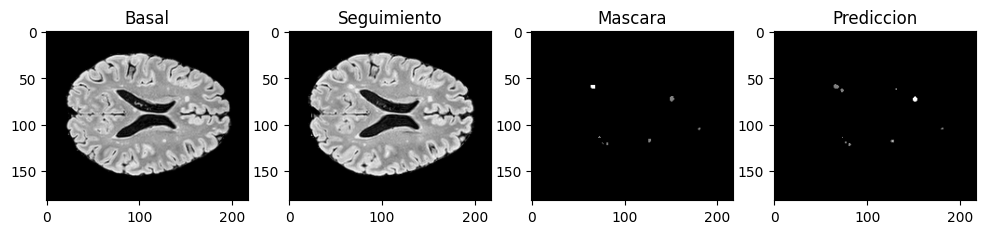

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_099_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_099_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_099_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_099_01.nii.gz
tf.Tensor(1.0261713, shape=(), dtype=float32)


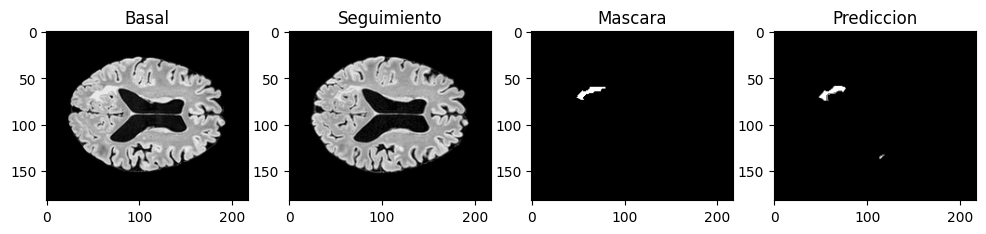

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_102_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_102_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_102_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_102_01.nii.gz
tf.Tensor(0.5847897, shape=(), dtype=float32)


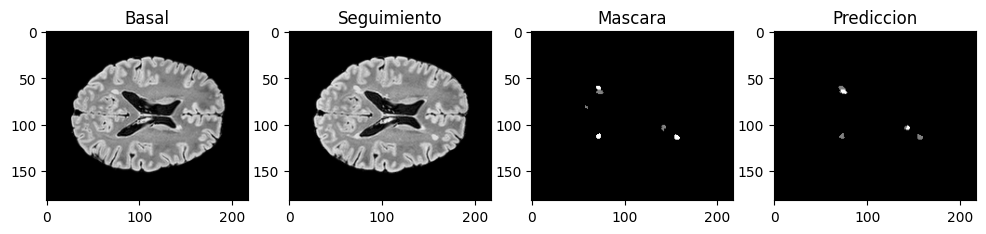

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_103_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_103_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_103_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_103_01.nii.gz
tf.Tensor(1.0627288, shape=(), dtype=float32)


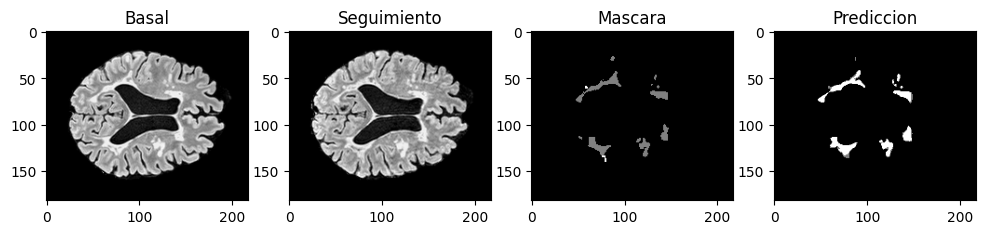

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_105_01_0000.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MS/FIS_105_01_0001.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MS/FIS_105_mask_def.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_multiclase_tm/FIS_105_01.nii.gz
tf.Tensor(1.0271615, shape=(), dtype=float32)


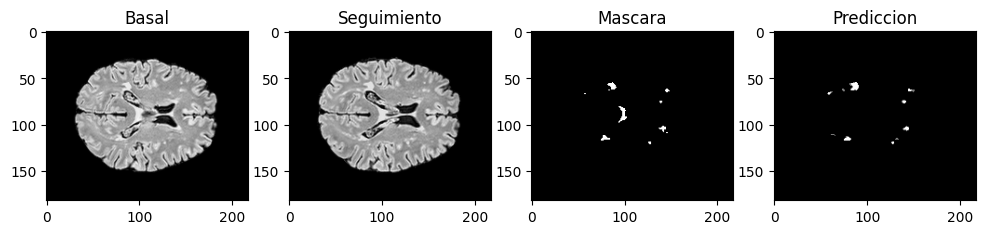

In [ ]:
# Mostramos las imágenes
def muestra_imagenes(i):
  imagen_bas = nib.load(img_basales_TM[i]).get_fdata()
  imagen_seg = nib.load(img_seguimiento_TM[i]).get_fdata()
  mascara = nib.load(y_true[i]).get_fdata()
  prediccion =nib.load(y_pred[i]).get_fdata()
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
  ax1.imshow(imagen_bas[:, :, imagen_bas.shape[2]//2],cmap='gray')
  ax1.set_title('Basal')
  ax2.imshow(imagen_seg[:, :, imagen_seg.shape[2]//2],cmap='gray')
  ax2.set_title('Seguimiento')
  ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
  ax3.set_title('Mascara')
  ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
  ax4.set_title('Prediccion')
  print(img_basales_TM[i])
  print(img_seguimiento_TM[i])
  print(y_true[i])
  print(y_pred[i])
  print(valoresDICE[i])
  plt.show()
  plt.close()
for i in range(23):
  muestra_imagenes(i)

# Testeo  del detector de nuevas lesiones con imágenes del MSSEG-2

Ahora testearemos el detector de nuevas imágenes con los datos del challenge MSSEG-2. Para ello primero transformaremos las imágenes para que nnU-Net pueda trabajar con ellas.

In [ ]:
root_dir = "/content/drive/MyDrive"
# Dividimos las imágenes en máscaras e imágenes de entrenamiento. Tomaremos la imagen más reciente del paciente como baseline.
total_imagenes_MSSEG =sorted(glob(os.path.join(root_dir,'MSSEG','*')))
mascaras_MSSEG = list(filter(lambda x: x.find("mask") !=-1, total_imagenes_MSSEG)) 
img_basales_MSSEG = list(filter(lambda x: x.find("time01") !=-1 , total_imagenes_MSSEG))
img_seguimiento_MSSEG = list(filter(lambda x: x.find("time02") !=-1 , total_imagenes_MSSEG) )
# Mostramos el total de imágenes y las primeras imágenes de cada lista
print("Total_imagenes:",len(total_imagenes_MSSEG))
print("img_basales:",len(img_basales_MSSEG))
print("img_seguimiento:",len(img_seguimiento_MSSEG))
print("mascaras:",len(mascaras_MSSEG))

Total_imagenes: 121
img_basales: 40
img_seguimiento: 40
mascaras: 40


In [ ]:
# Código para transformar las imágenes a un formato que le guste a nnU-Net
def copia_imagenes_test(origen, img_dir, image_dir, label_dir):
   ruta, file = os.path.split(origen)
   if file.endswith('.nii.gz'):
        # En ambos casos vamos a renombrar, tomamos el nombre original
        original_name = os.path.join(img_dir, file)

        # Separamos la base y la extensión
        base, extension = os.path.splitext(file)
        
        if file.find('mask')!=-1:
            # Tenemos una máscara, la renombramos para que el framework la reconozca
            # quitando '_mask_def'
            # nueva_base = base.replace('_mask_def','')
            nueva_ruta = os.path.join(label_dir,base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        elif file.find('time01')!=-1:
            nueva_base = base.replace('time01_FL','0000')
            nueva_ruta = os.path.join(image_dir,"BAS_"+nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        elif file.find('time02')!=-1:
            nueva_base = base.replace('time02_FL','0000')
            nueva_ruta = os.path.join(image_dir,"SEG_"+nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)



In [ ]:
# Creamos los directorios
make_if_dont_exist(task_folder_name+"/imagesTs_MSSEG",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTs_MSSEG",overwrite=False)

test_image_dir = os.path.join(task_folder_name,'imagesTs_MSSEG')
test_label_dir = os.path.join(task_folder_name,'labelsTs_MSSEG')

img_dir_MSSEG = '/content/drive/MyDrive/MSSEG'

i = 0
while i < 40:
  image_dir = test_image_dir
  label_dir = test_label_dir   
  
  # Tomamos el archivo
  img_basal = img_basales_MSSEG[i]
  img_seg = img_seguimiento_MSSEG[i]
  etiqueta = mascaras_MSSEG[i]

  copia_imagenes_test(img_basal, img_dir_MSSEG,image_dir,label_dir)
  copia_imagenes_test(img_seg, img_dir_MSSEG,image_dir,label_dir)
  copia_imagenes_test(etiqueta, img_dir_MSSEG,image_dir,label_dir)
  # Incrementamos i
  i = i+1

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/imagesTs_MSSEG exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG exists.


NameError: ignored

Ponemos a trabajar el detector de nuevas lesiones

In [ ]:
test_image_dir = os.path.join(task_folder_name,'imagesTs_MSSEG')
test_label_dir = os.path.join(task_folder_name,'labelsTs_MSSEG')

img_dir_MSSEG = '/content/drive/MyDrive/MSSEG'
dir_destino = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias'
i = 0
while i <40:
  image_dir = test_image_dir
  
  # Tomamos el archivo
  img_basal = img_basales_MSSEG[i]
  img_seg = img_seguimiento_MSSEG[i]

  copia_imagenes_test(img_basal, img_dir_MSSEG,dir_destino,dir_destino)
  copia_imagenes_test(img_seg, img_dir_MSSEG,dir_destino,dir_destino)
  detecta_nuevas_lesiones(dir_destino)
  # Borramos ficheros copiados para volver a empezar
  test = os.listdir(image_dir)

  for item in test:
      if item.endswith(".nii.gz"):
          if os.path.exists(os.path.join(dir_destino, item)):
            os.remove(os.path.join(dir_destino, item))
  # Incrementamos i
  i = i+1

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados created!
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados

Aplicamos el postprocesado

In [ ]:
! nnUNetv2_apply_postprocessing -i "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados" -o "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados_postprocesados" -pp_pkl_file "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset102_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/crossval_results_folds_0/postprocessing.pkl" 

## Obtención del valor de DICE de nuestro modelo

Vamos a obtener el valor dice promedio y la desviación típica para ver la bondad de nuestro modelo:


In [ ]:
# Preparamos los dos conjuntos de datos para comparar
test_folder_name = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias'
x_test = sorted(glob(os.path.join(task_folder_name,'imagesTs_MSSEG','*')))
y_true = sorted(glob(os.path.join(task_folder_name,'labelsTs_MSSEG','*')))

ficheros_p = sorted(glob(os.path.join(test_folder_name,"resultados",'*')))
# Tomamos sólo las imágenes de las predicciones
y_pred = list(filter(lambda x:x.endswith(".nii.gz") , ficheros_p))
print("test files:",len(x_test))
print("true mask files:",len(y_true))
print("predicted mask files:",len(y_pred))

test files: 80
true mask files: 40
predicted mask files: 40


In [ ]:
valoresDICE = []

for i in range(40):  
   predict = nib.load(y_pred[i]).get_fdata()
   label = nib.load(y_true[i]).get_fdata()
   DICE = dice(label, predict)
   valoresDICE.append(DICE)

Ya tenemos los valores de DICE de cada predicción en una lista, obtenemos la media y desviación

In [ ]:
# Ya tenemos la lista de valores, ahora obtenemos el promedio
media_DICE = np.mean(valoresDICE)
std_DICE = np.std(valoresDICE)

# Mostramos datos
print("Valor medio de DICE:",media_DICE)
print("Desviación típica de DICE:",std_DICE)
valoresDICE

Valor medio de DICE: 0.17481428
Desviación típica de DICE: 0.21211964


[<tf.Tensor: shape=(), dtype=float32, numpy=0.029896207>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.347637e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4274864>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.8587326e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.393821e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.2091752e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.25281918>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.26874748>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.25883022>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35933673>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.6099776e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.22102155>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.787269e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1588629>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.031330112>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64691496>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.36564228>,
 <tf.Tensor: sha

Hemos obtenido un valor medio de DICE de 0.17481428 y una desviación típica de 0.21211964


## Matriz de confusión de nuestro modelo

Elaboramos la matriz de confusión de nuestro modelo con los datos del MSSEG-2

In [ ]:
conf_m = torch.zeros(2,2) # tenemos 2 clases
# Recorreremos las imágenes para ir sumando la matriz de confusion
for i in range(60):    
    prediction = nib.load(y_pred[i]).get_fdata()
    label = nib.load(y_true[i]).get_fdata()
    conf_m = confusion_matrix(prediction, label,conf_m, 60)

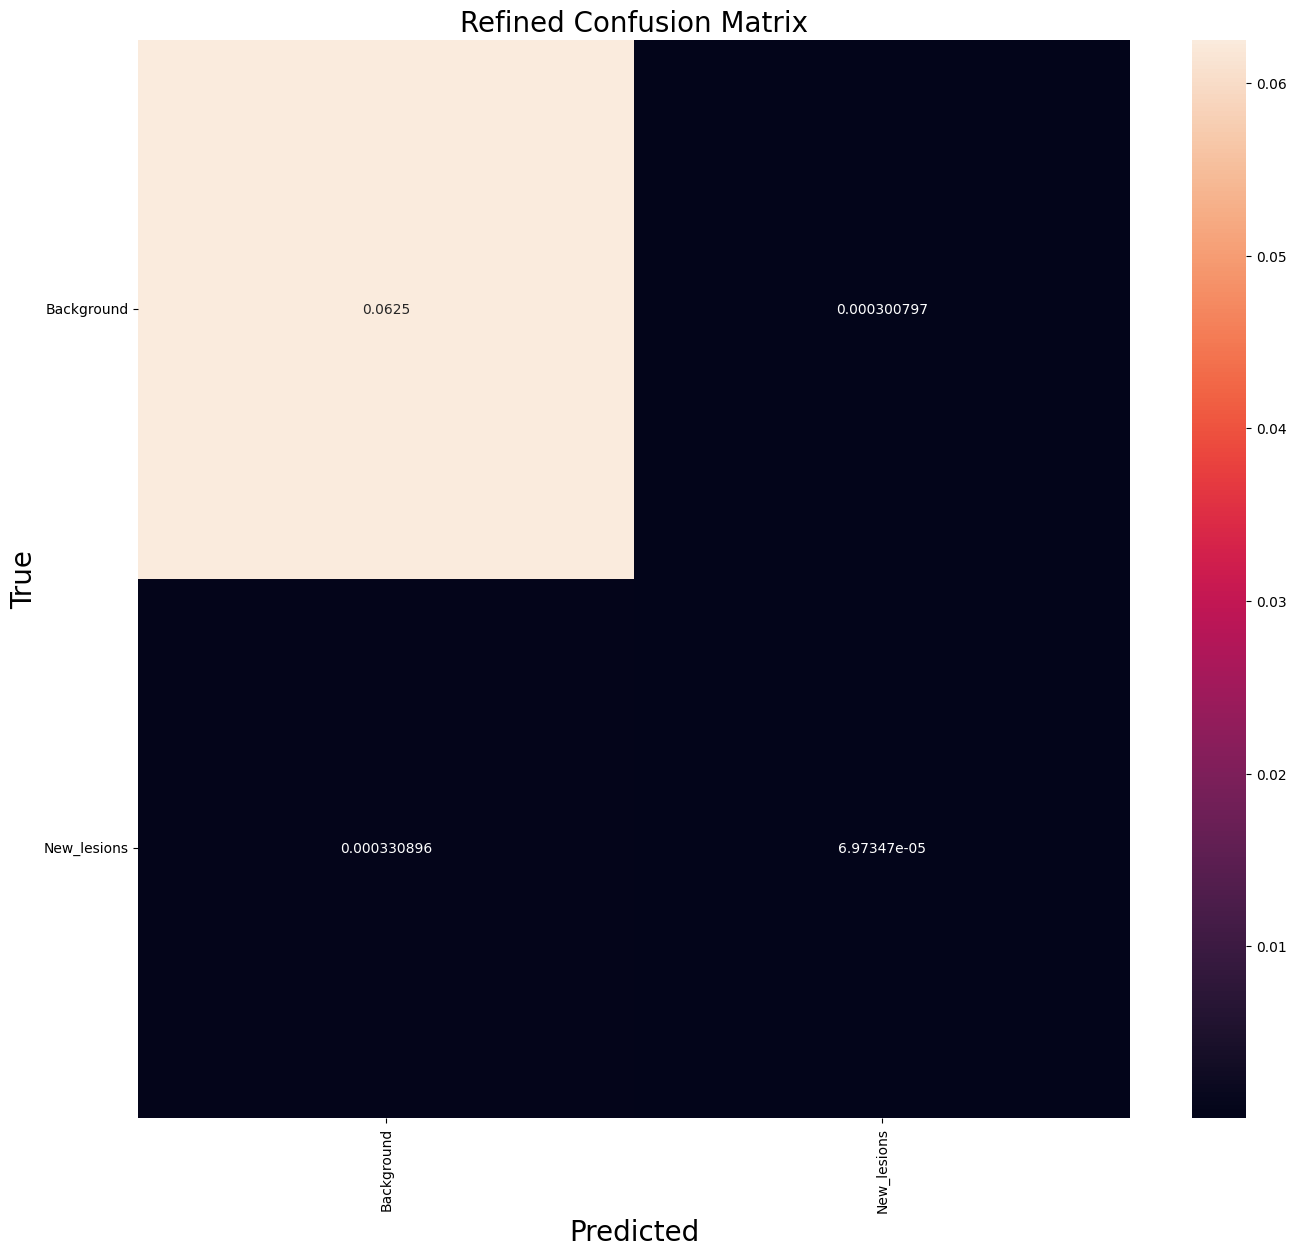

In [ ]:
## Indicamos las etiquetas
class_names = ['Background','New_lesions']
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(conf_m, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# Damos formato a todo
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

## Comparación visual de imágenes

Veamos de manera visual las imágenes segmentadas vs las máscaras

/content/drive/MyDrive/MSSEG/013_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/013_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/013_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/013.nii.gz
tf.Tensor(0.029896207, shape=(), dtype=float32)


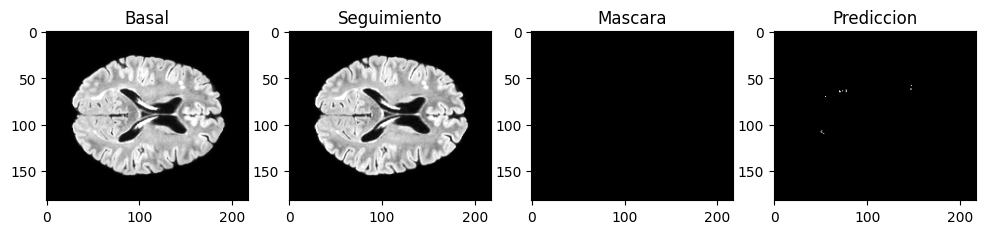

/content/drive/MyDrive/MSSEG/015_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/015_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/015_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/015.nii.gz
tf.Tensor(4.347637e-05, shape=(), dtype=float32)


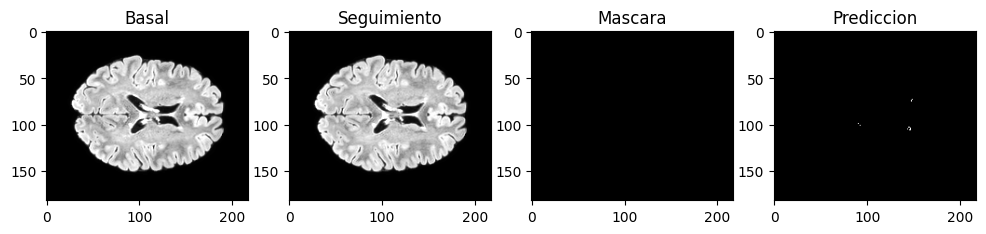

/content/drive/MyDrive/MSSEG/016_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/016_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/016_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/016.nii.gz
tf.Tensor(0.4274864, shape=(), dtype=float32)


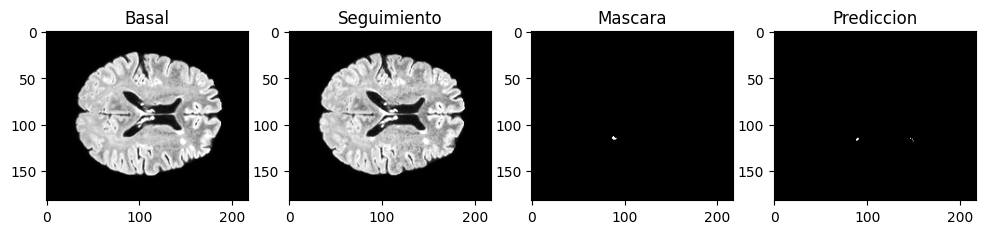

/content/drive/MyDrive/MSSEG/018_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/018_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/018_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/018.nii.gz
tf.Tensor(1.8587326e-06, shape=(), dtype=float32)


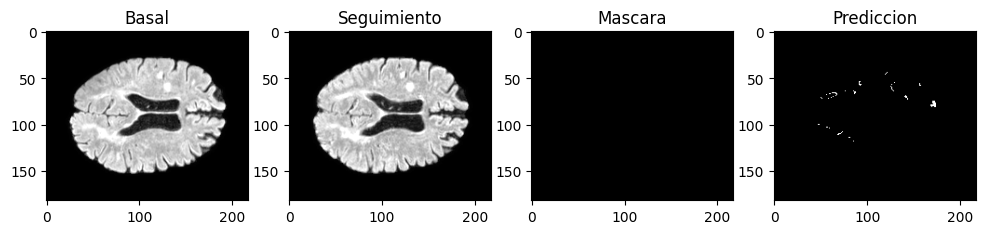

/content/drive/MyDrive/MSSEG/019_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/019_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/019_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/019.nii.gz
tf.Tensor(6.393821e-06, shape=(), dtype=float32)


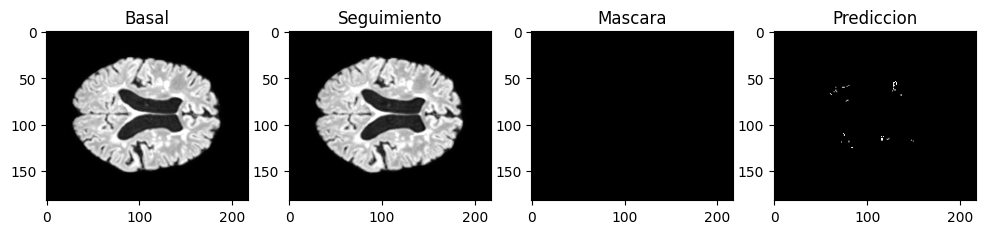

/content/drive/MyDrive/MSSEG/020_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/020_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/020_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/020.nii.gz
tf.Tensor(1.2091752e-05, shape=(), dtype=float32)


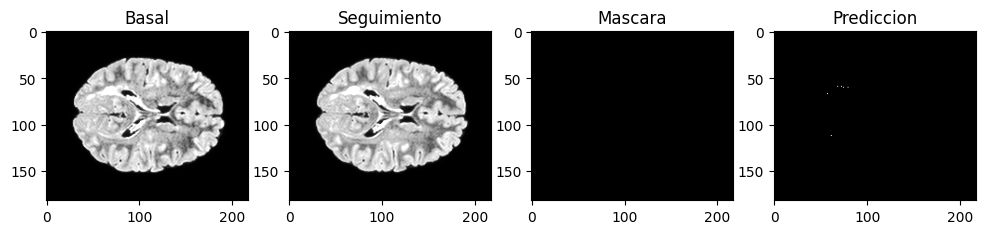

/content/drive/MyDrive/MSSEG/021_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/021_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/021_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/021.nii.gz
tf.Tensor(0.25281918, shape=(), dtype=float32)


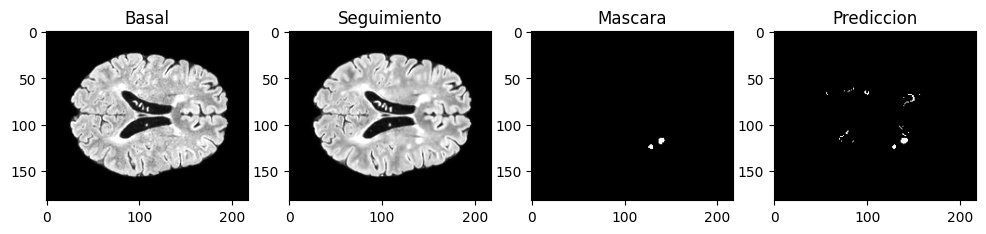

/content/drive/MyDrive/MSSEG/024_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/024_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/024_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/024.nii.gz
tf.Tensor(0.26874748, shape=(), dtype=float32)


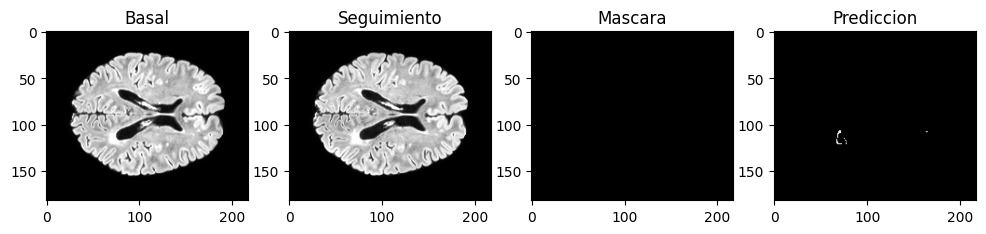

/content/drive/MyDrive/MSSEG/026_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/026_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/026_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/026.nii.gz
tf.Tensor(0.25883022, shape=(), dtype=float32)


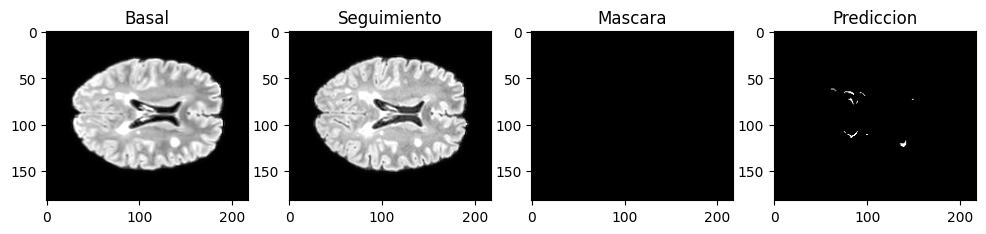

/content/drive/MyDrive/MSSEG/027_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/027_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/027_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/027.nii.gz
tf.Tensor(0.35933673, shape=(), dtype=float32)


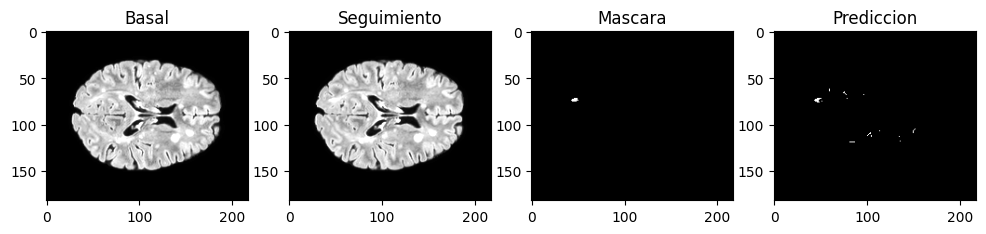

/content/drive/MyDrive/MSSEG/029_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/029_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/029_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/029.nii.gz
tf.Tensor(3.6099776e-05, shape=(), dtype=float32)


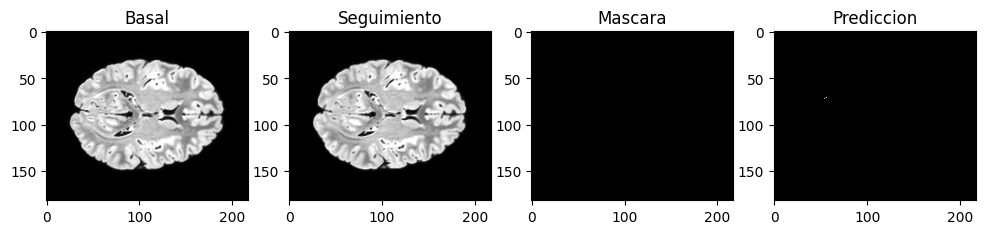

/content/drive/MyDrive/MSSEG/030_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/030_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/030_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/030.nii.gz
tf.Tensor(0.22102155, shape=(), dtype=float32)


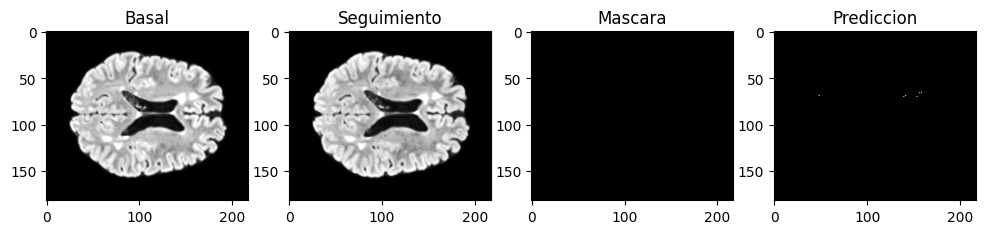

/content/drive/MyDrive/MSSEG/032_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/032_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/032_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/032.nii.gz
tf.Tensor(8.787269e-06, shape=(), dtype=float32)


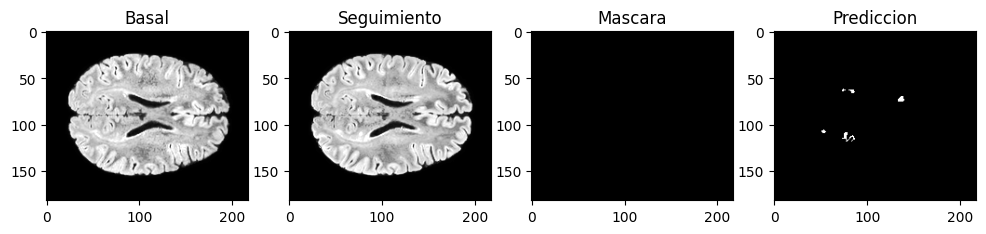

/content/drive/MyDrive/MSSEG/035_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/035_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/035_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/035.nii.gz
tf.Tensor(0.1588629, shape=(), dtype=float32)


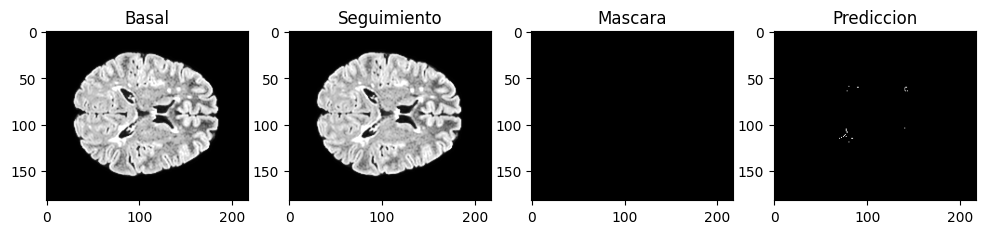

/content/drive/MyDrive/MSSEG/037_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/037_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/037_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/037.nii.gz
tf.Tensor(0.031330112, shape=(), dtype=float32)


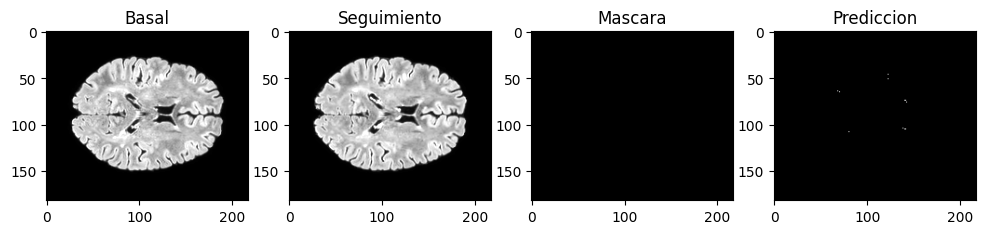

/content/drive/MyDrive/MSSEG/039_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/039_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/039_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/039.nii.gz
tf.Tensor(0.64691496, shape=(), dtype=float32)


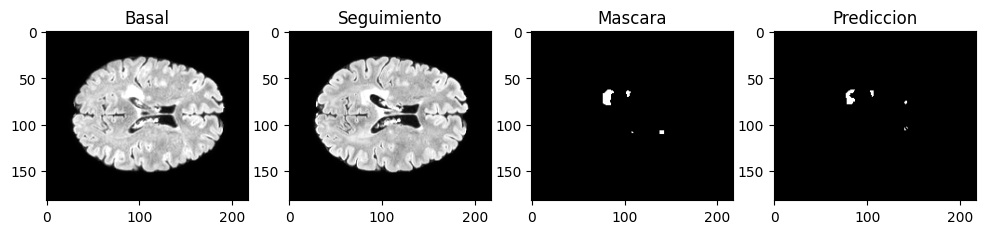

/content/drive/MyDrive/MSSEG/043_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/043_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/043_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/043.nii.gz
tf.Tensor(0.36564228, shape=(), dtype=float32)


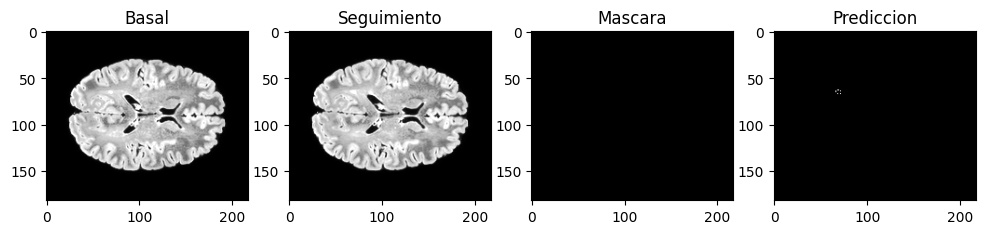

/content/drive/MyDrive/MSSEG/047_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/047_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/047_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/047.nii.gz
tf.Tensor(0.0055998405, shape=(), dtype=float32)


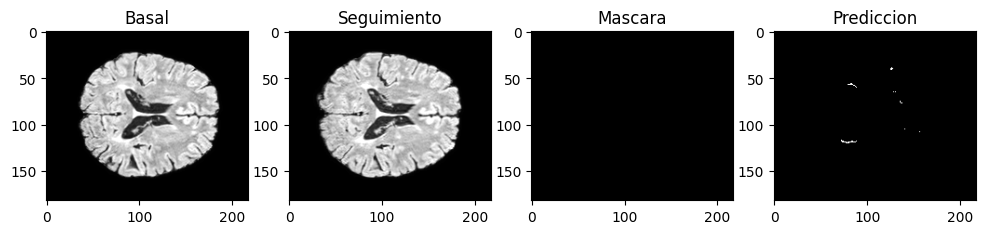

/content/drive/MyDrive/MSSEG/048_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/048_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/048_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/048.nii.gz
tf.Tensor(0.28071076, shape=(), dtype=float32)


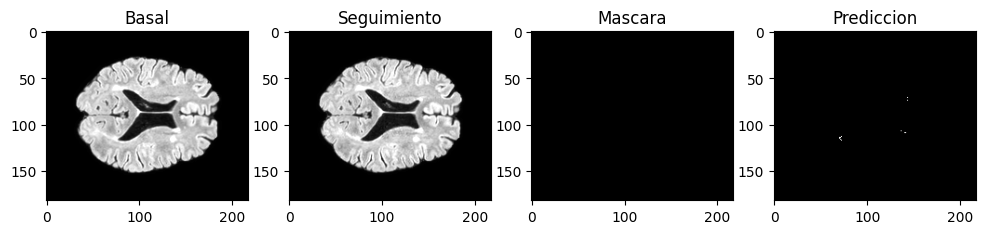

/content/drive/MyDrive/MSSEG/049_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/049_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/049_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/049.nii.gz
tf.Tensor(8.944464e-06, shape=(), dtype=float32)


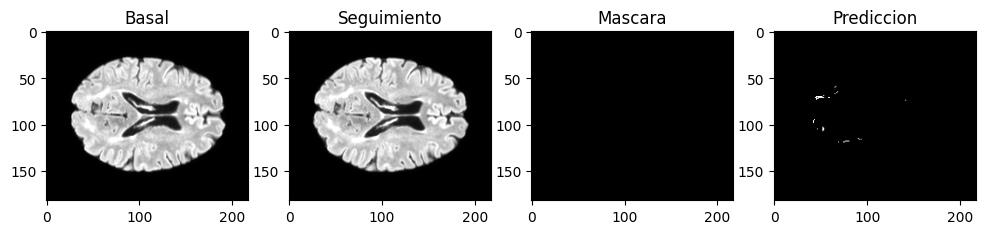

/content/drive/MyDrive/MSSEG/051_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/051_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/051_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/051.nii.gz
tf.Tensor(6.8026748e-06, shape=(), dtype=float32)


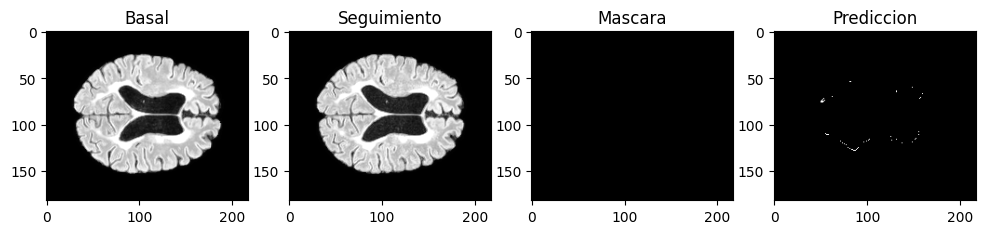

/content/drive/MyDrive/MSSEG/052_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/052_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/052_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/052.nii.gz
tf.Tensor(2.3808956e-05, shape=(), dtype=float32)


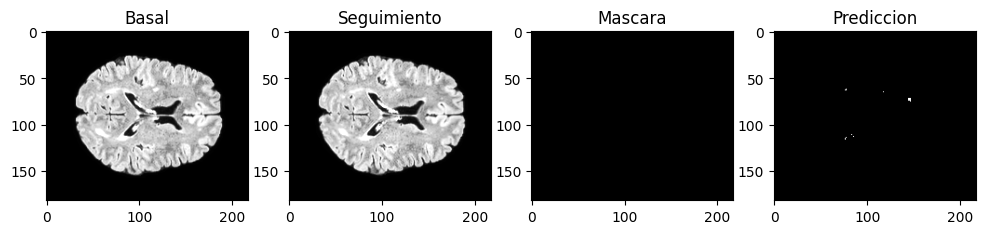

/content/drive/MyDrive/MSSEG/057_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/057_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/057_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/057.nii.gz
tf.Tensor(0.37613106, shape=(), dtype=float32)


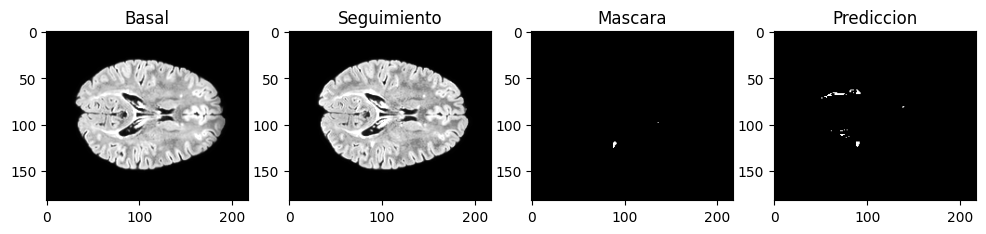

/content/drive/MyDrive/MSSEG/061_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/061_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/061_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/061.nii.gz
tf.Tensor(0.28103384, shape=(), dtype=float32)


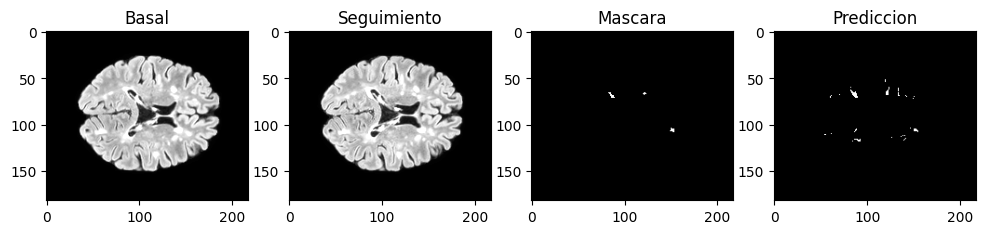

/content/drive/MyDrive/MSSEG/068_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/068_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/068_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/068.nii.gz
tf.Tensor(9.756002e-06, shape=(), dtype=float32)


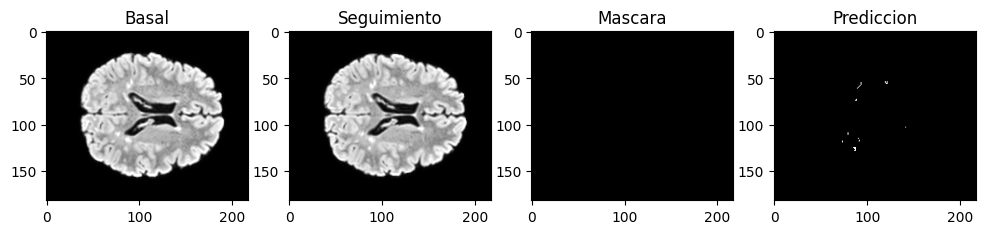

/content/drive/MyDrive/MSSEG/069_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/069_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/069_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/069.nii.gz
tf.Tensor(0.6036193, shape=(), dtype=float32)


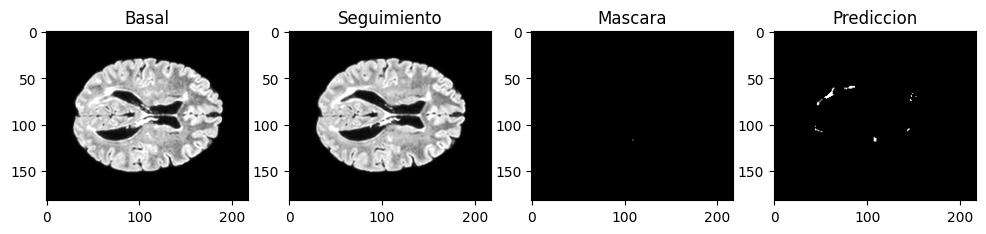

/content/drive/MyDrive/MSSEG/070_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/070_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/070_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/070.nii.gz
tf.Tensor(6.6137127e-06, shape=(), dtype=float32)


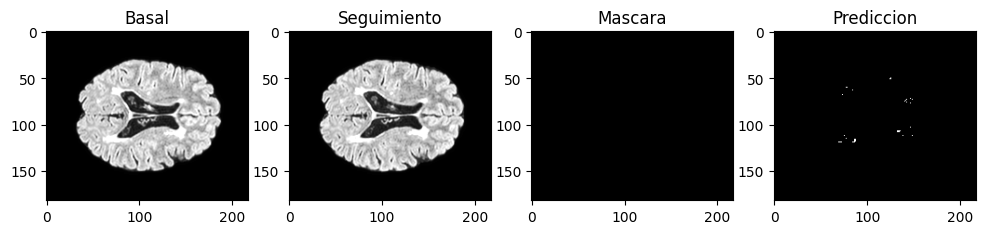

/content/drive/MyDrive/MSSEG/074_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/074_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/074_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/074.nii.gz
tf.Tensor(0.50343996, shape=(), dtype=float32)


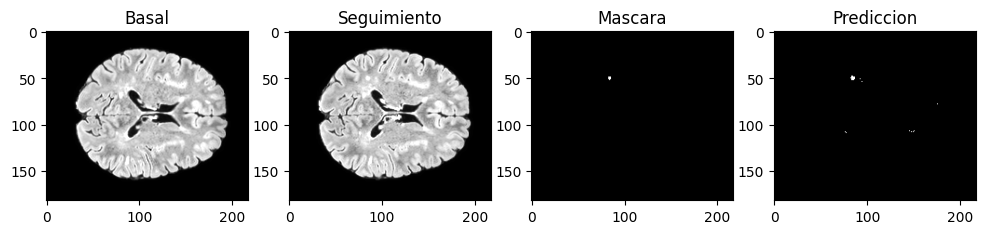

/content/drive/MyDrive/MSSEG/077_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/077_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/077_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/077.nii.gz
tf.Tensor(0.14946808, shape=(), dtype=float32)


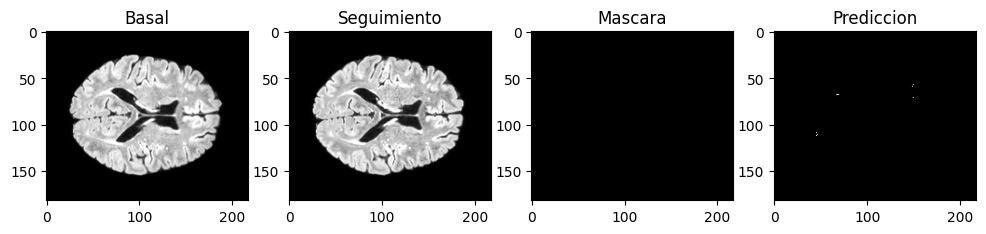

/content/drive/MyDrive/MSSEG/083_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/083_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/083_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/083.nii.gz
tf.Tensor(0.44220197, shape=(), dtype=float32)


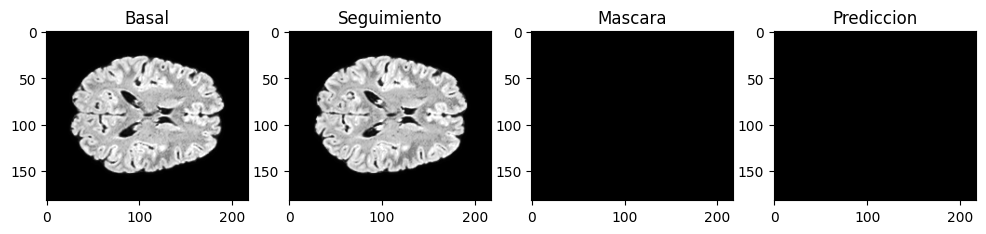

/content/drive/MyDrive/MSSEG/084_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/084_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/084_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/084.nii.gz
tf.Tensor(8.3326384e-05, shape=(), dtype=float32)


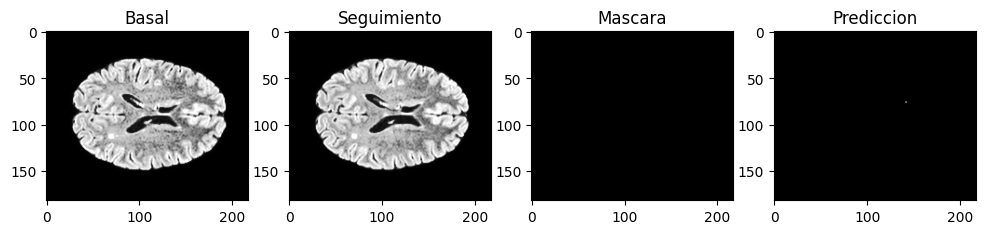

/content/drive/MyDrive/MSSEG/088_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/088_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/088_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/088.nii.gz
tf.Tensor(4.132214e-06, shape=(), dtype=float32)


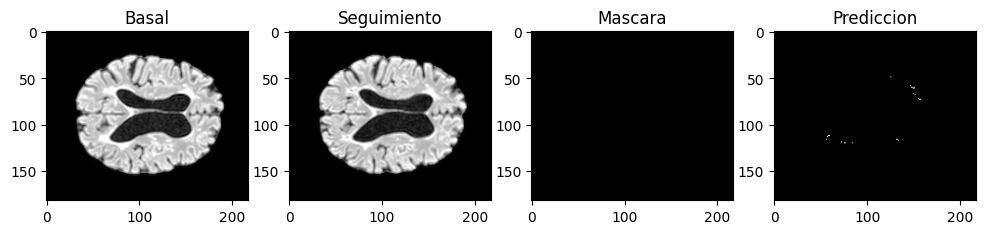

/content/drive/MyDrive/MSSEG/089_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/089_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/089_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/089.nii.gz
tf.Tensor(3.42454e-05, shape=(), dtype=float32)


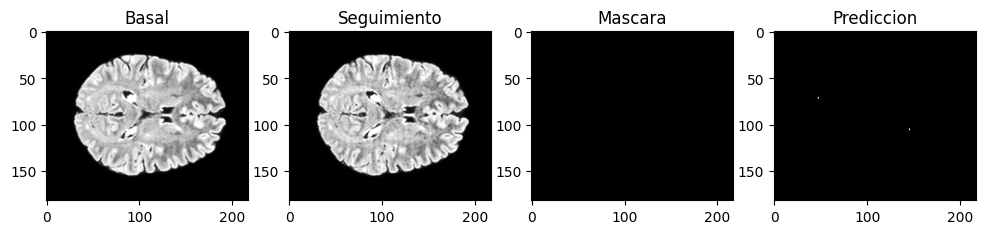

/content/drive/MyDrive/MSSEG/090_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/090_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/090_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/090.nii.gz
tf.Tensor(3.4375955e-06, shape=(), dtype=float32)


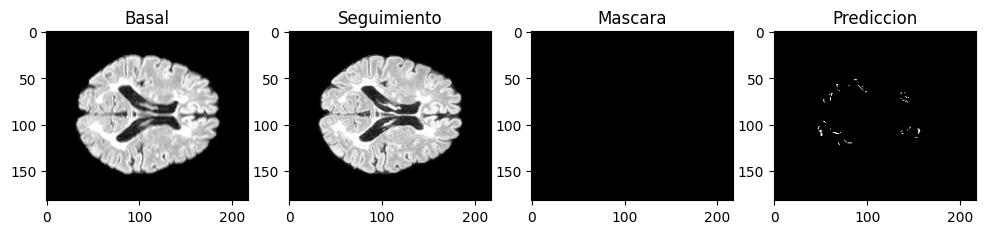

/content/drive/MyDrive/MSSEG/091_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/091_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/091_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/091.nii.gz
tf.Tensor(0.53062093, shape=(), dtype=float32)


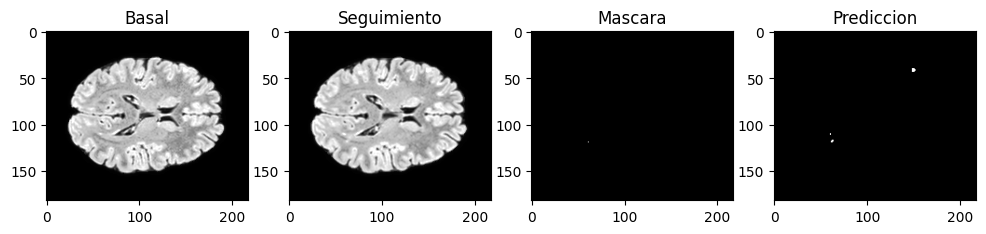

/content/drive/MyDrive/MSSEG/094_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/094_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/094_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/094.nii.gz
tf.Tensor(0.11065508, shape=(), dtype=float32)


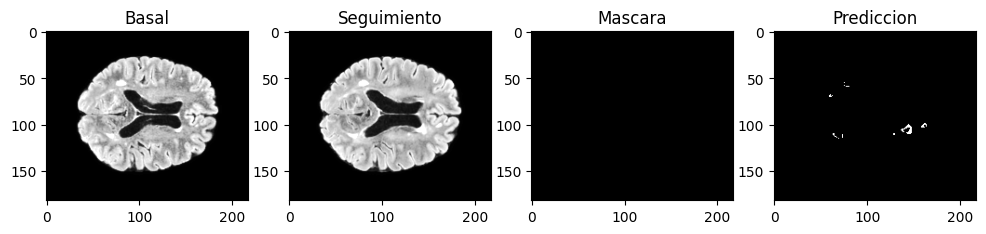

/content/drive/MyDrive/MSSEG/095_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/095_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/095_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/095.nii.gz
tf.Tensor(0.67080194, shape=(), dtype=float32)


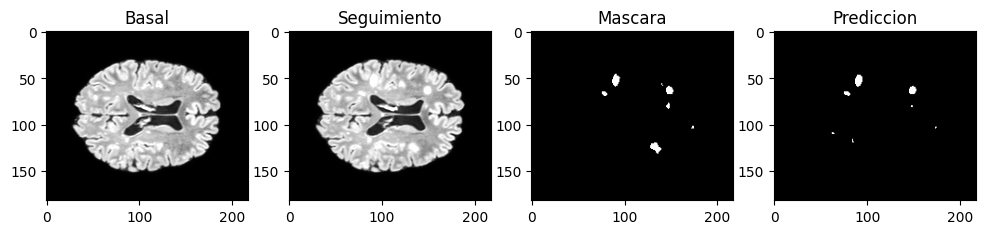

/content/drive/MyDrive/MSSEG/096_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/096_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/096_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/096.nii.gz
tf.Tensor(0.0004543389, shape=(), dtype=float32)


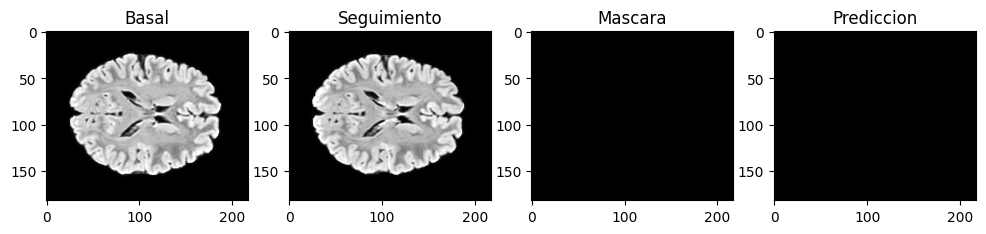

/content/drive/MyDrive/MSSEG/099_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/099_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/099_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/099.nii.gz
tf.Tensor(2.5251886e-05, shape=(), dtype=float32)


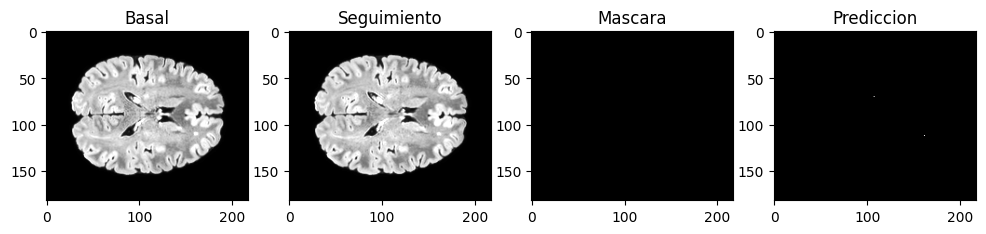

/content/drive/MyDrive/MSSEG/100_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/100_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/labelsTs_MSSEG/100_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset102_SLEM/Test_diferencias/resultados/100.nii.gz
tf.Tensor(0.01663084, shape=(), dtype=float32)


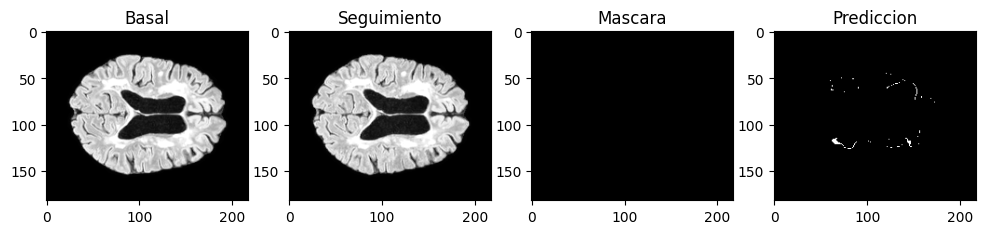

In [ ]:
# Mostramos las imágenes
def muestra_imagenes(i):
  imagen_bas = nib.load(img_basales_MSSEG[i]).get_fdata()
  imagen_seg = nib.load(img_seguimiento_MSSEG[i]).get_fdata()
  mascara = nib.load(y_true[i]).get_fdata()
  prediccion =nib.load(y_pred[i]).get_fdata()
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
  ax1.imshow(imagen_bas[:, :, imagen_bas.shape[2]//2],cmap='gray')
  ax1.set_title('Basal')
  ax2.imshow(imagen_seg[:, :, imagen_seg.shape[2]//2],cmap='gray')
  ax2.set_title('Seguimiento')
  ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
  ax3.set_title('Mascara')
  ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
  ax4.set_title('Prediccion')
  print(img_basales_MSSEG[i])
  print(img_seguimiento_MSSEG[i])
  print(y_true[i])
  print(y_pred[i])
  print(valoresDICE[i])
  plt.show()
  plt.close()
for i in range(40):
  muestra_imagenes(i)

# Exportación del modelo
Exportamos el modelo obtenido

In [ ]:
 !nnUNetv2_export_model_to_zip -d Dataset102_SLEM  -c 3d_fullres -tr nnUNetTrainer_100epochsCheck -o '/content/drive/MyDrive/Colab Notebooks/modeloFinal/Modelo.zip' 

Configuration 3d_fullres
Exporting fold_0
No ensemble directory found for task Dataset102_SLEM
